In [103]:
from Levenshtein import distance as levenshtein
from zipfile import ZipFile
from tqdm.notebook import tqdm, trange
import ncbi.datasets
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
# Plotting configuration
sns.set()
plt.rcParams.update({
    'text.usetex': False,
    'figure.constrained_layout.use': True,
    'figure.dpi': 300,
    'figure.figsize': ((W := 8.27 - 2*0.04167 - 2*(PAD := 0.2)), W/(3/2)),
    'savefig.pad_inches': 2*0.041672 + PAD,
    'savefig.bbox': 'tight',
    'font.size' : 11,
    'axes.labelsize': 11,
    'legend.fontsize': 11,
})
if plt.rcParams['text.usetex']:
    plt.rcParams.update({
        'text.latex.preamble': (
            r'\usepackage{lmodern}'
            r'\usepackage[T1]{fontenc}'
            r'\usepackage[utf8]{inputenc}'
            r'\usepackage{siunitx}'
            r'\usepackage{physics}'
            r'\usepackage{sansmath}'           # Disable for roman font
            r'\sansmath'                       # *
        ),
        # 'font.family': 'lmodern',              # Disable for sans-serif
    })
%config InlineBackend.figure_formats = 'png' #'svg', 'pdf', 'retina'


---

In [3]:
species = pd.read_csv('../dat/data.csv')
species

id                          name  \
0    GCA_905340225.1          Abrostola tripartita   
1    GCF_001949145.1      crown-of-thorns starfish   
2    GCA_016904835.1                      rifleman   
3    GCA_021347895.1                 spiny chromis   
4    GCF_904848185.1            yellowfin seabream   
..               ...                           ...   
719  GCA_020796205.1  Ziziphus jujuba var. spinosa   
720  GCF_000696155.1       Zootermopsis nevadensis   
721  GCF_011800845.1                 common lizard   
722  GCA_907165275.2          Zygaena filipendulae   
723  GCA_002219185.1            [Candida] glabrata   

                                                   dna  
0    AAAATCTTCCACCTGCTGAACATTCATATAATGAACTTCCAATTTT...  
1    AGATAGAAACTGACCTGGCTCACGCCGGTCTGAACTCAGATCACGT...  
2    GTCCCTGTAGCTTAATAAAAAGCATAACACTGAAGATGTTAAGACG...  
3    GCGTAGCTTAACTAGAGCATAACTCTGAAGATGTTAGGGTGGACCT...  
4    GCTCACGTAGCTTAATTAAAGCATAACATTGAAGCCGTTAAGATGG...  
..                                                 ...  
719  AGGGGCATCTTTCTTTCTCCCATTCTTTCTGTTGGTCAACAACCAA...  
720  AATGGAGTGCCTGAAAAAGGATTACTATGATAGGGTAAATAATGTA...  
721  GTCATTGTAGCTTATTTTTTTGAAAGCACGGCACTGAAAATGCCGA...  
722  ATTTAAAGCATTATTATTTATATGTGCTGGTGTTATTATCCATATA...  
723  TAAATATTTTAAACTTGTATAGTTTAAATGGTTAAAACATTTGTCT...  

[724 rows x 3 columns]

In [77]:
K_len = np.load('../dat/K_len.npy')
K_lev = np.load('../dat/K_lev.npy')

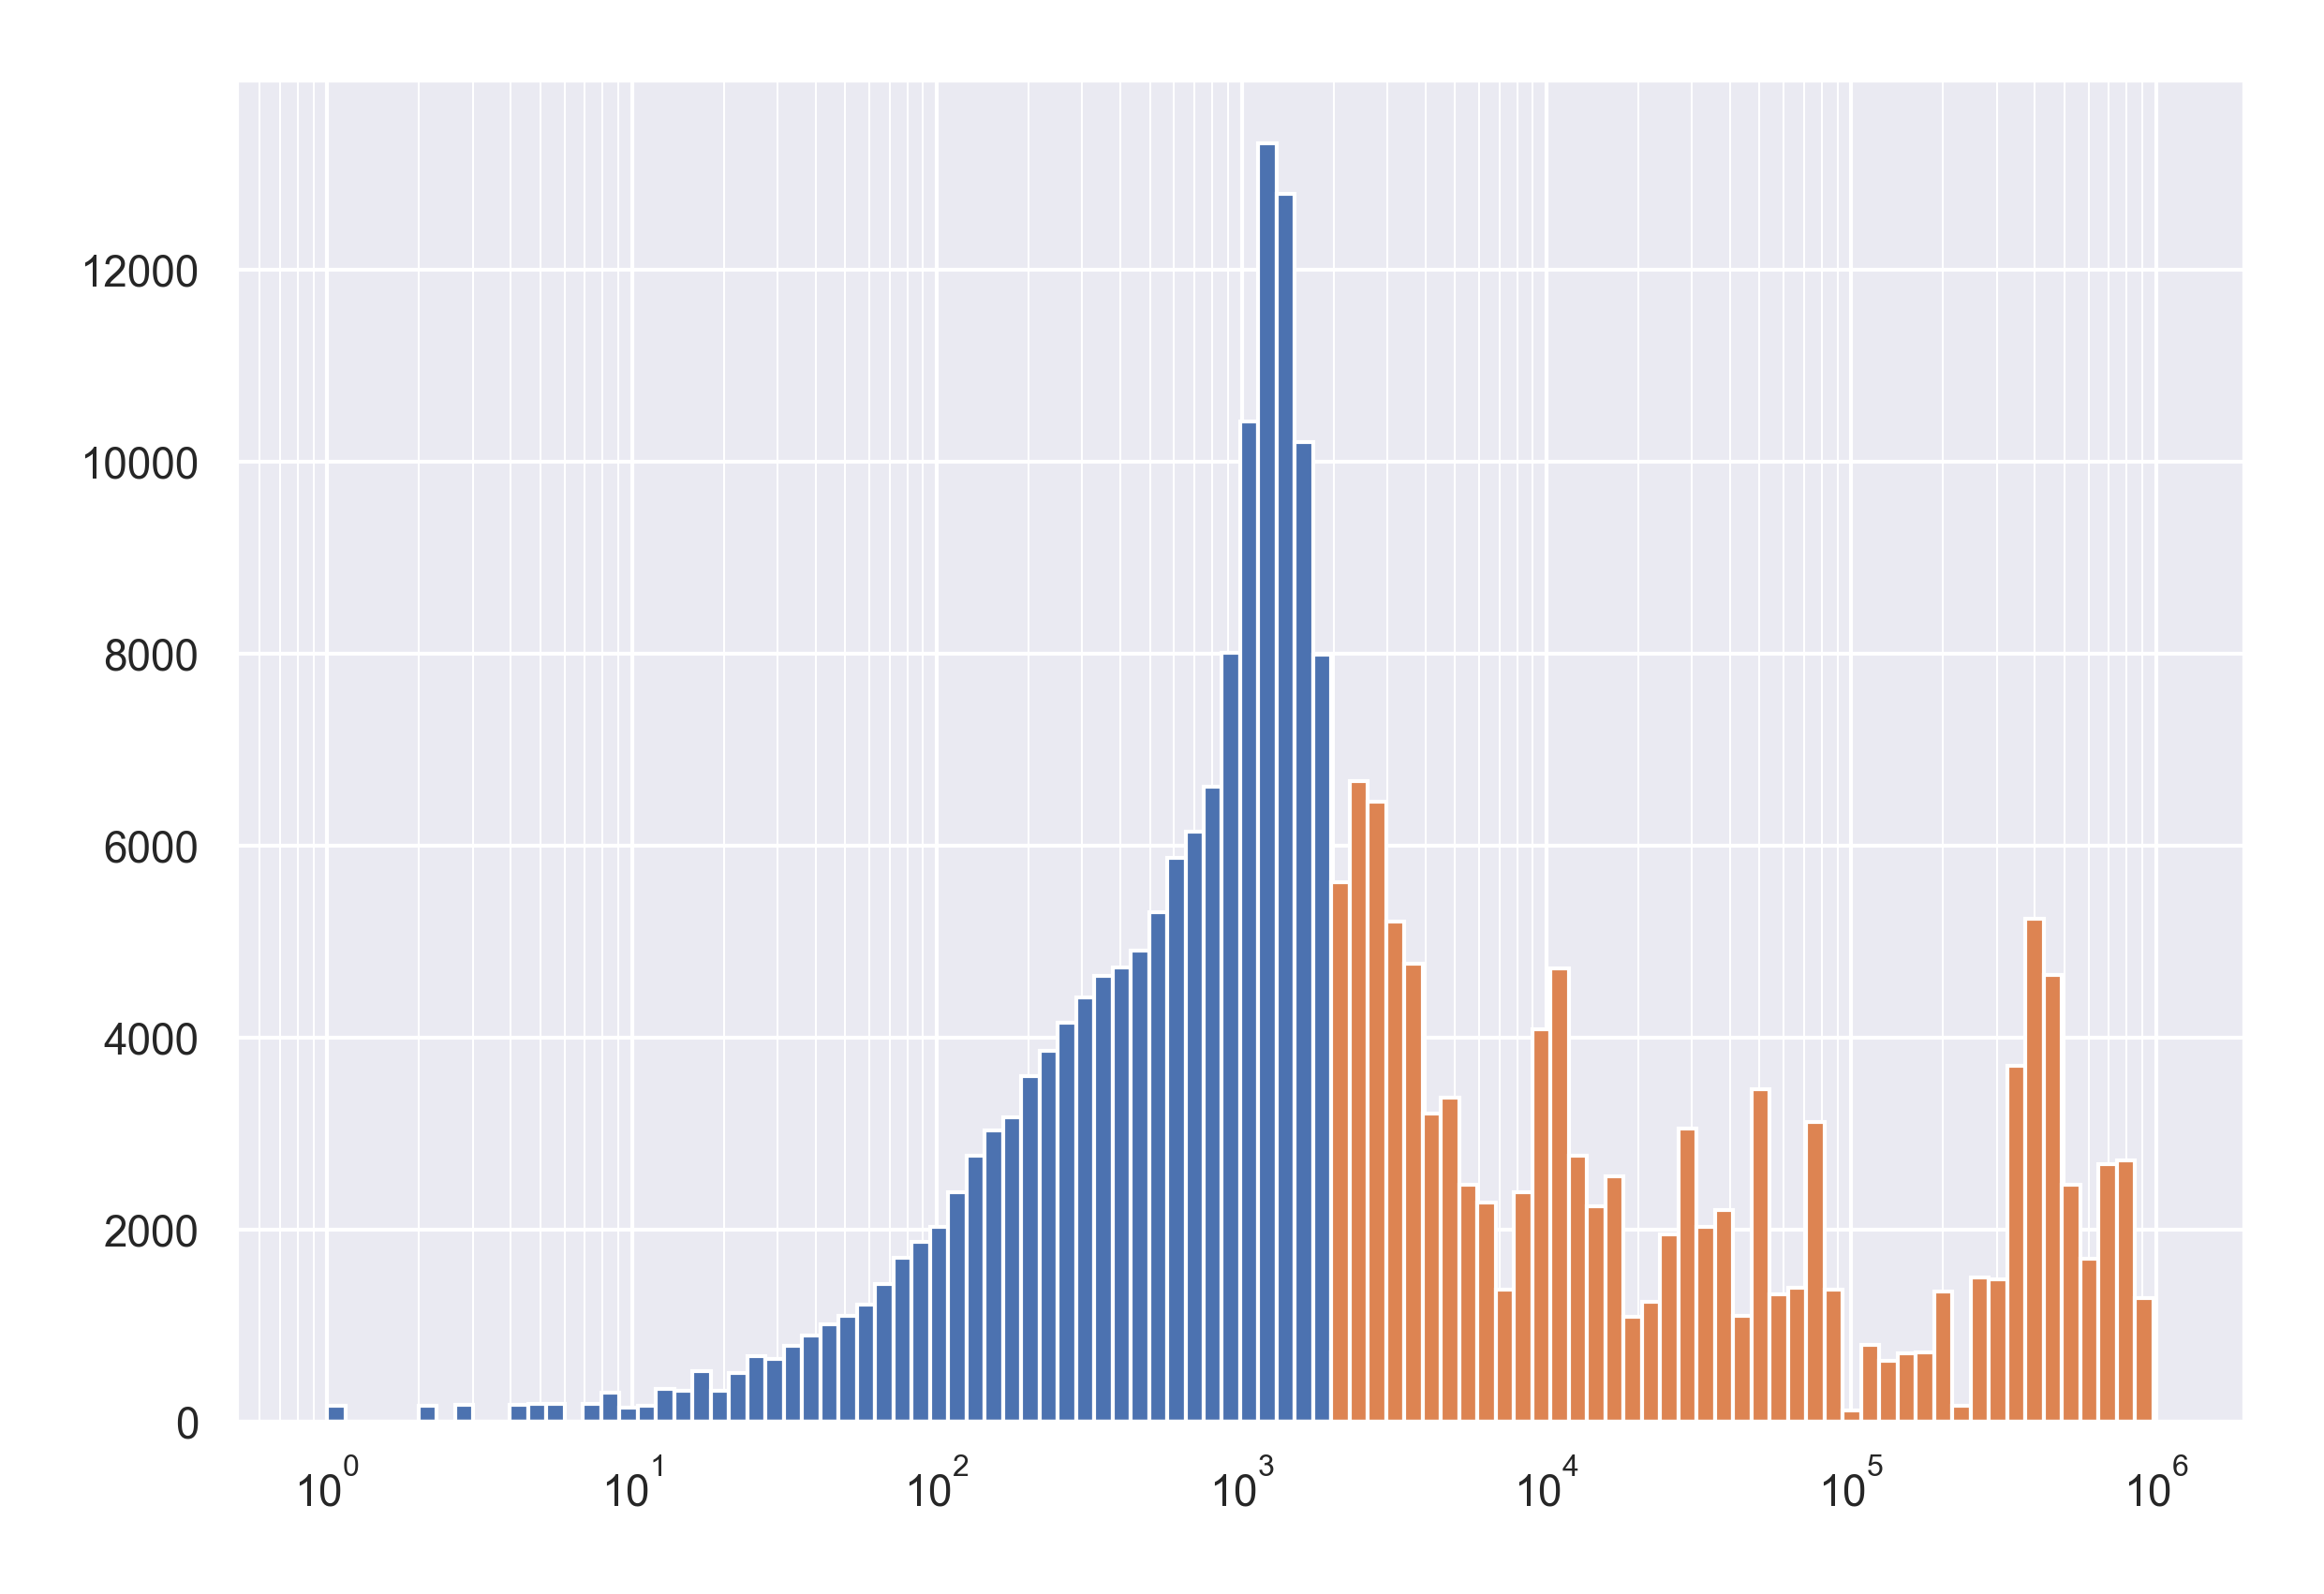

In [67]:
# histogram of length-distances: we will only use
lens = K_len[np.triu_indices(len(K_len), 1)]
lens = lens[lens > 0]
hist, bins, _ = plt.hist(lens, 100)
plt.close()

fig, ax = plt.subplots()
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax.hist(lens[lens < 2000], bins=logbins)
ax.hist(lens[lens >= 2000], bins=logbins)
ax.set_xscale('log')
ax.xaxis.grid(which='minor', lw=0.5)
plt.show()

  0%|          | 0/719 [00:00<?, ?it/s]

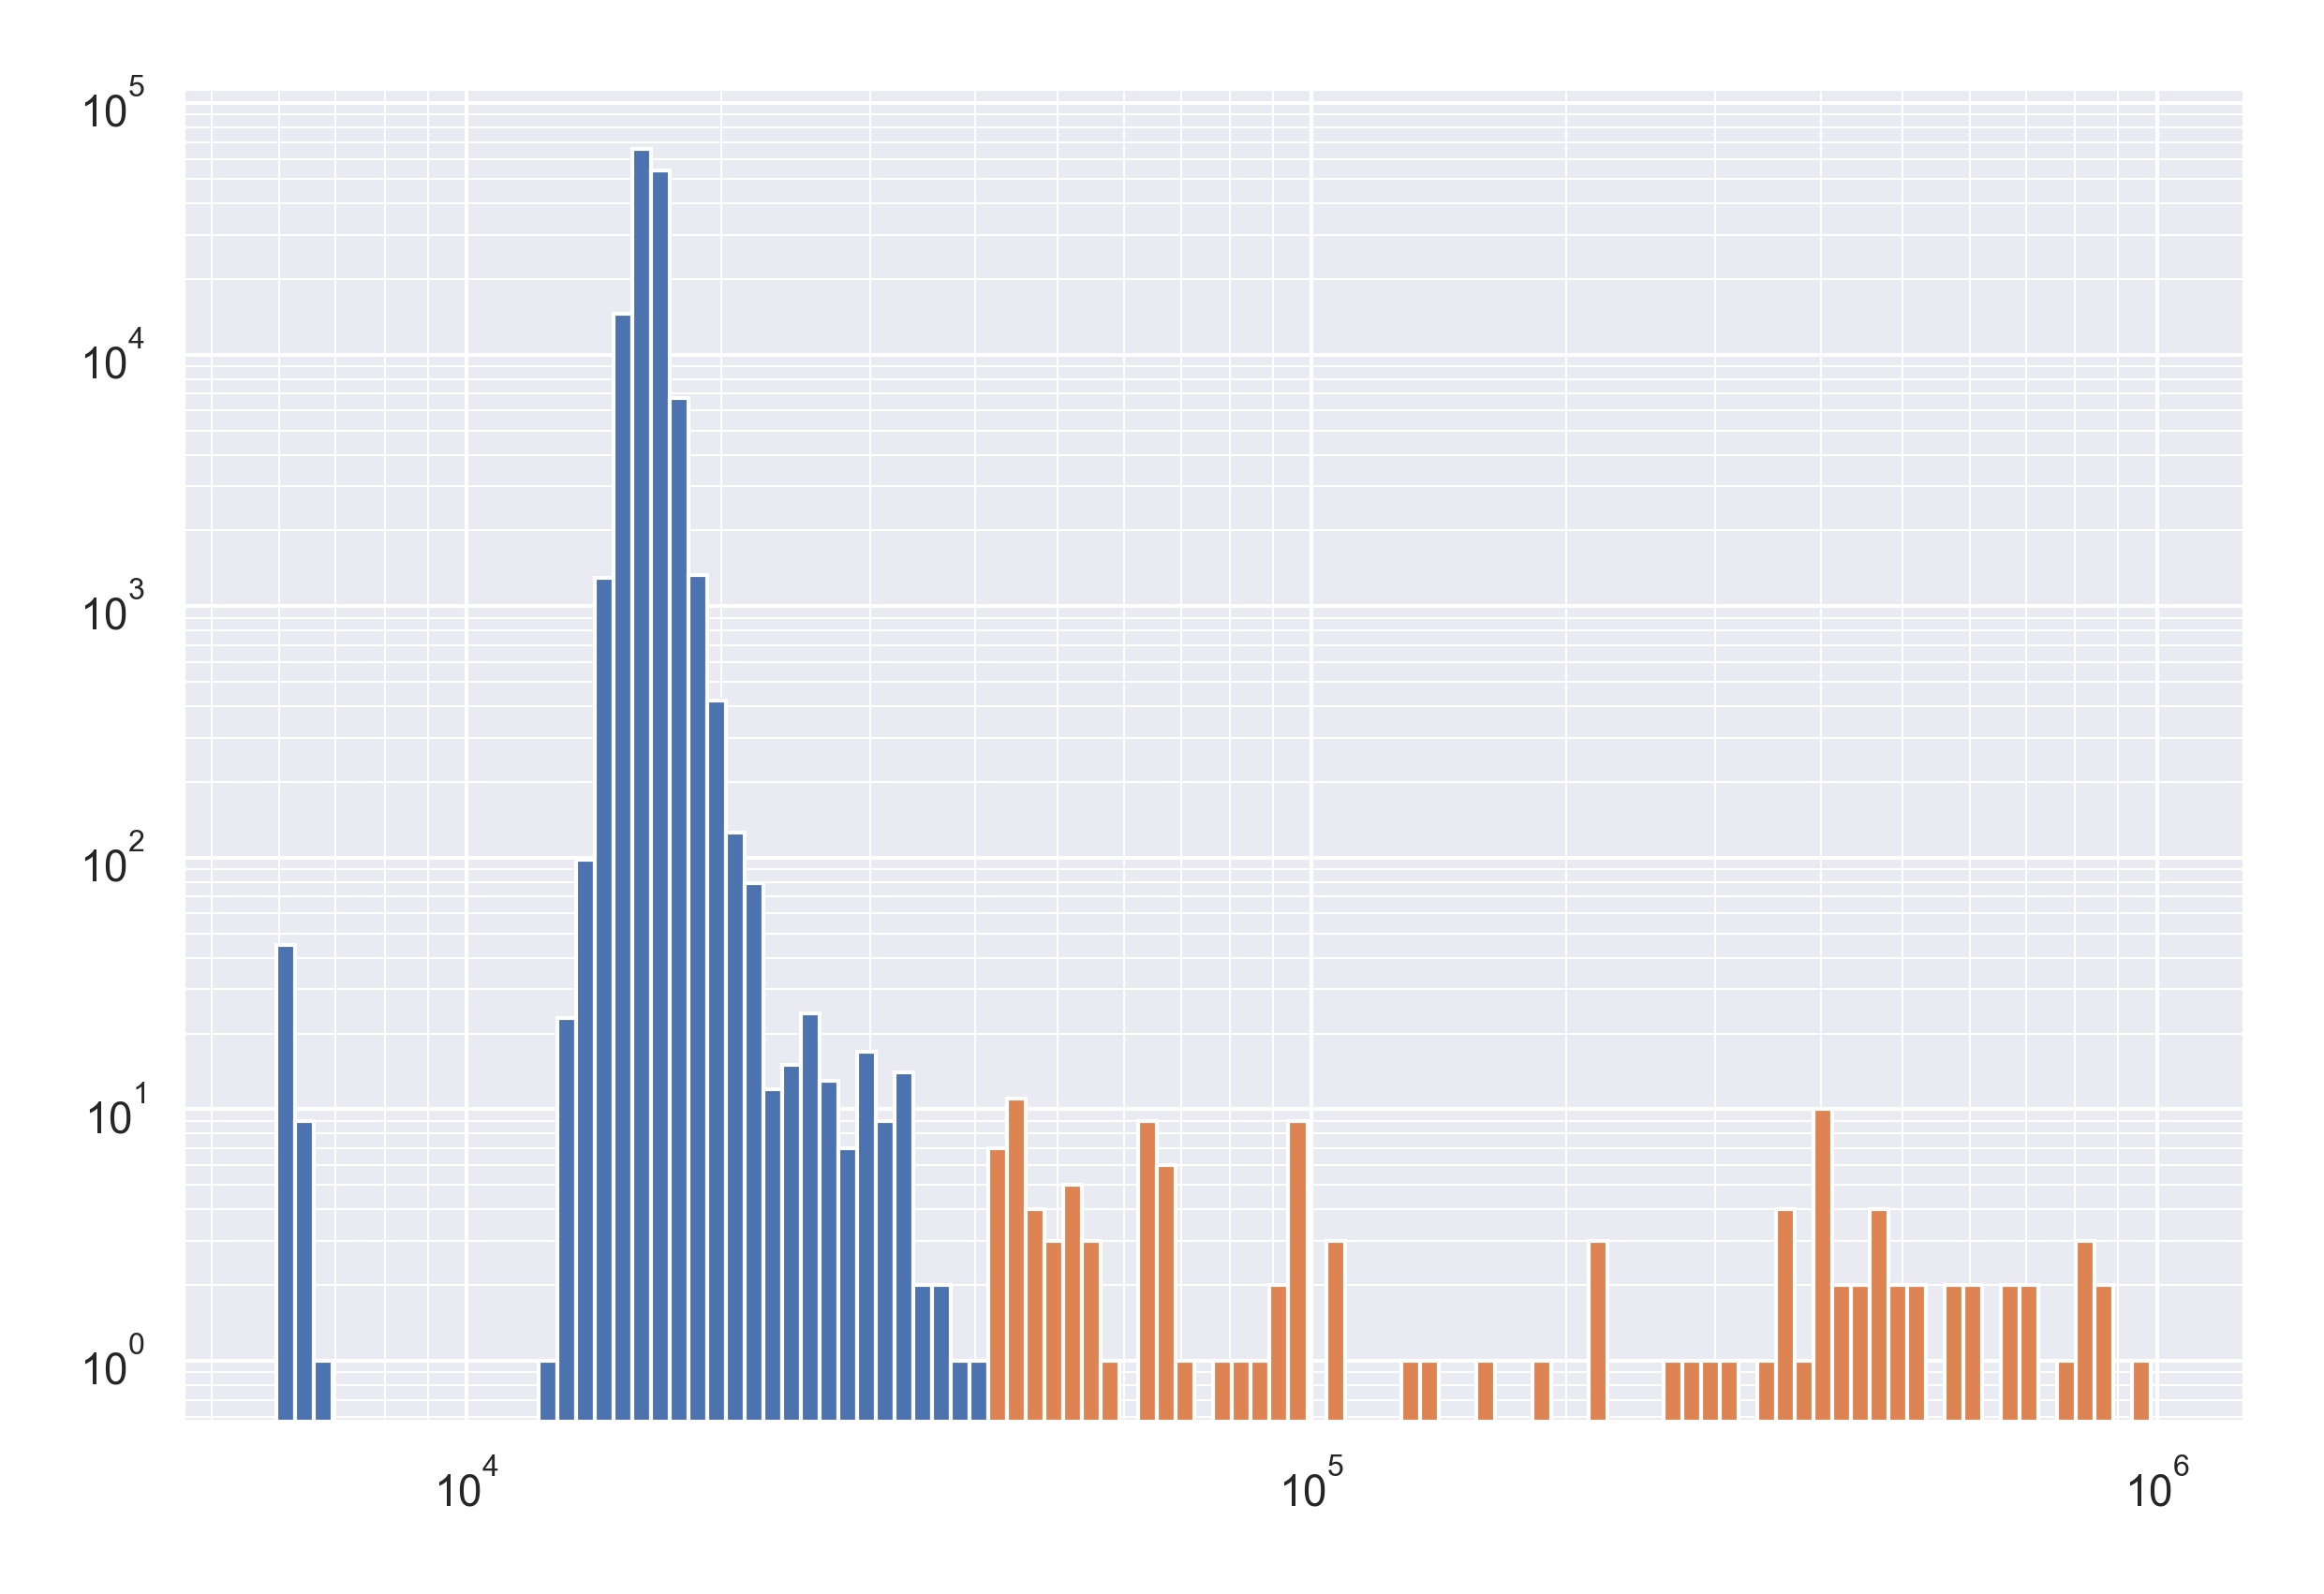

In [80]:
# Check lengths of dna sequences with len-distance < 2000
lens = []
for i in trange(5, len(species)):
    a = species.dna[i]
    for j in range(i, len(species)):
        b = species.dna[j]
        if K_len[i, j] < 2000:
            lens.append((len(a) + len(b)) // 2)
lens = np.asarray(lens)

hist, bins, _ = plt.hist(lens, 100)
plt.close()

fig, ax = plt.subplots()
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax.hist(lens[lens < 40_000], bins=logbins)
ax.hist(lens[lens >= 40_000], bins=logbins)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.grid(which='minor', lw=0.5)
ax.yaxis.grid(which='minor', lw=0.5)
plt.show()

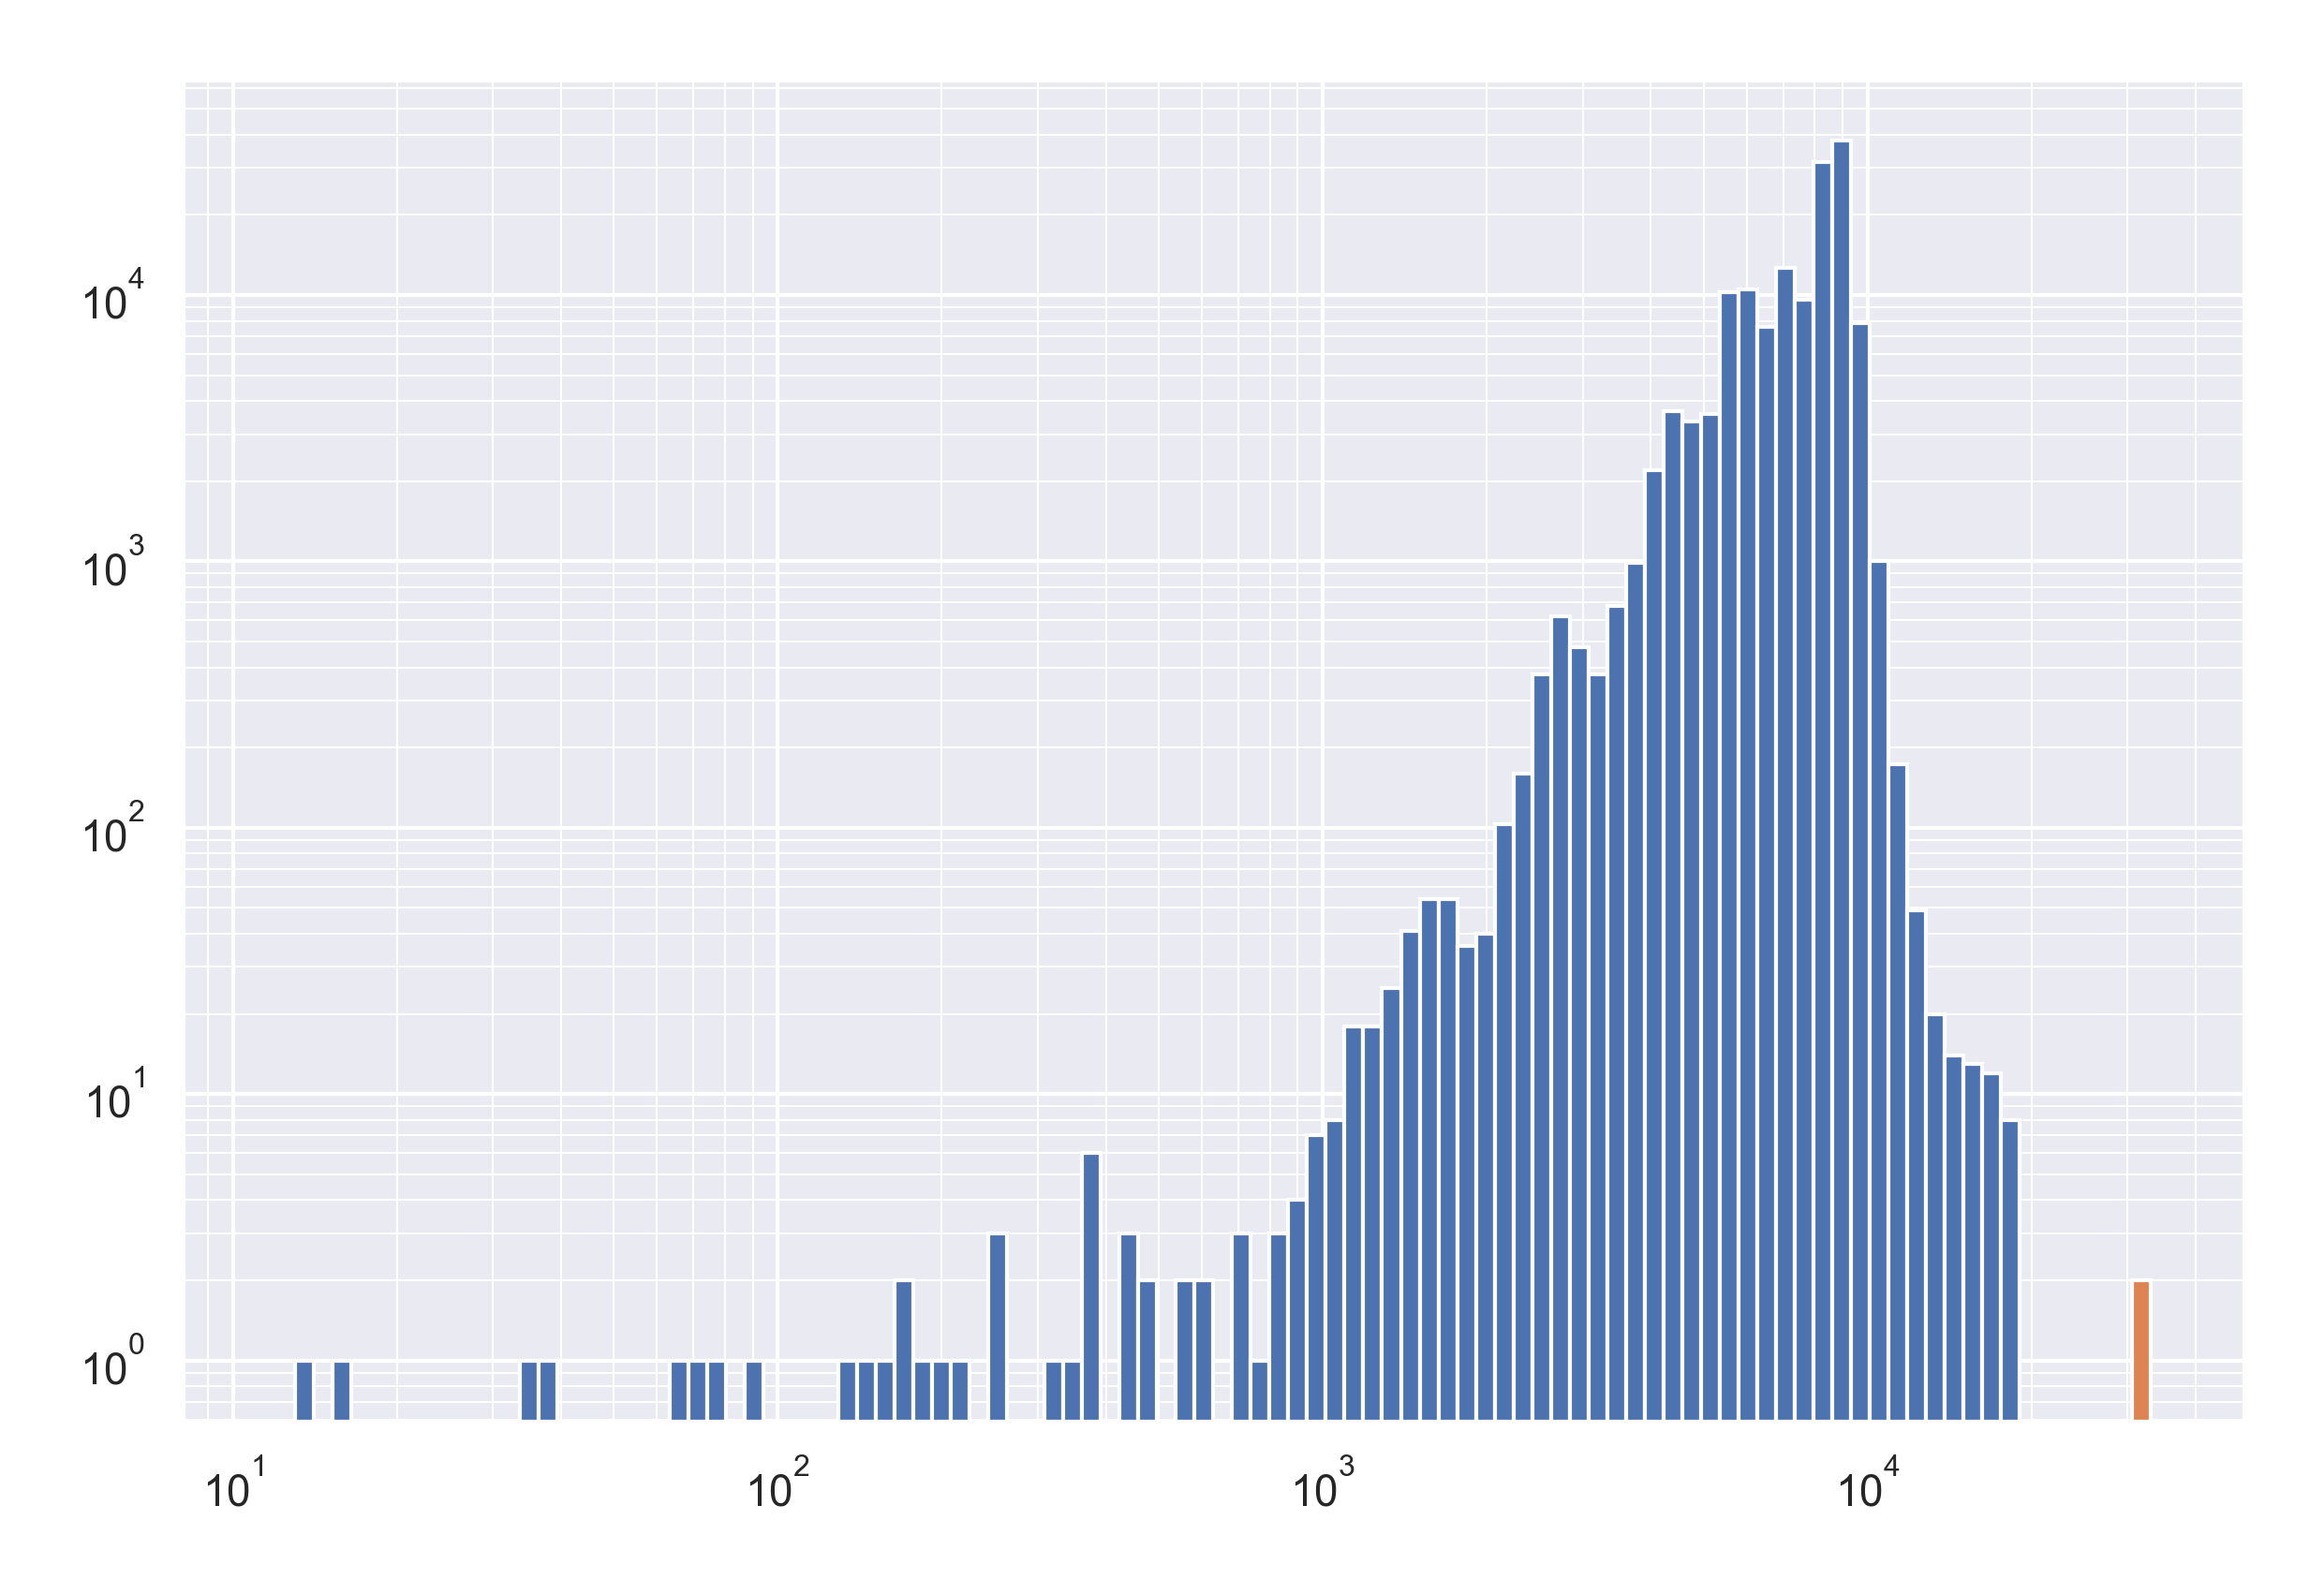

In [81]:
levs = K_lev[np.triu_indices(len(K_lev), 1)]
levs = levs[levs > 0]
hist, bins, _ = plt.hist(levs, 100)
plt.close()

fig, ax = plt.subplots()
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax.hist(levs[levs < 20_000], bins=logbins)
ax.hist(levs[levs >= 20_000], bins=logbins)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.grid(which='minor', lw=0.5)
ax.yaxis.grid(which='minor', lw=0.5)
plt.show()

/var/folders/b_/mrq467b11bv_32fb0lz46bgm0000gp/T/ipykernel_92503/2115431460.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


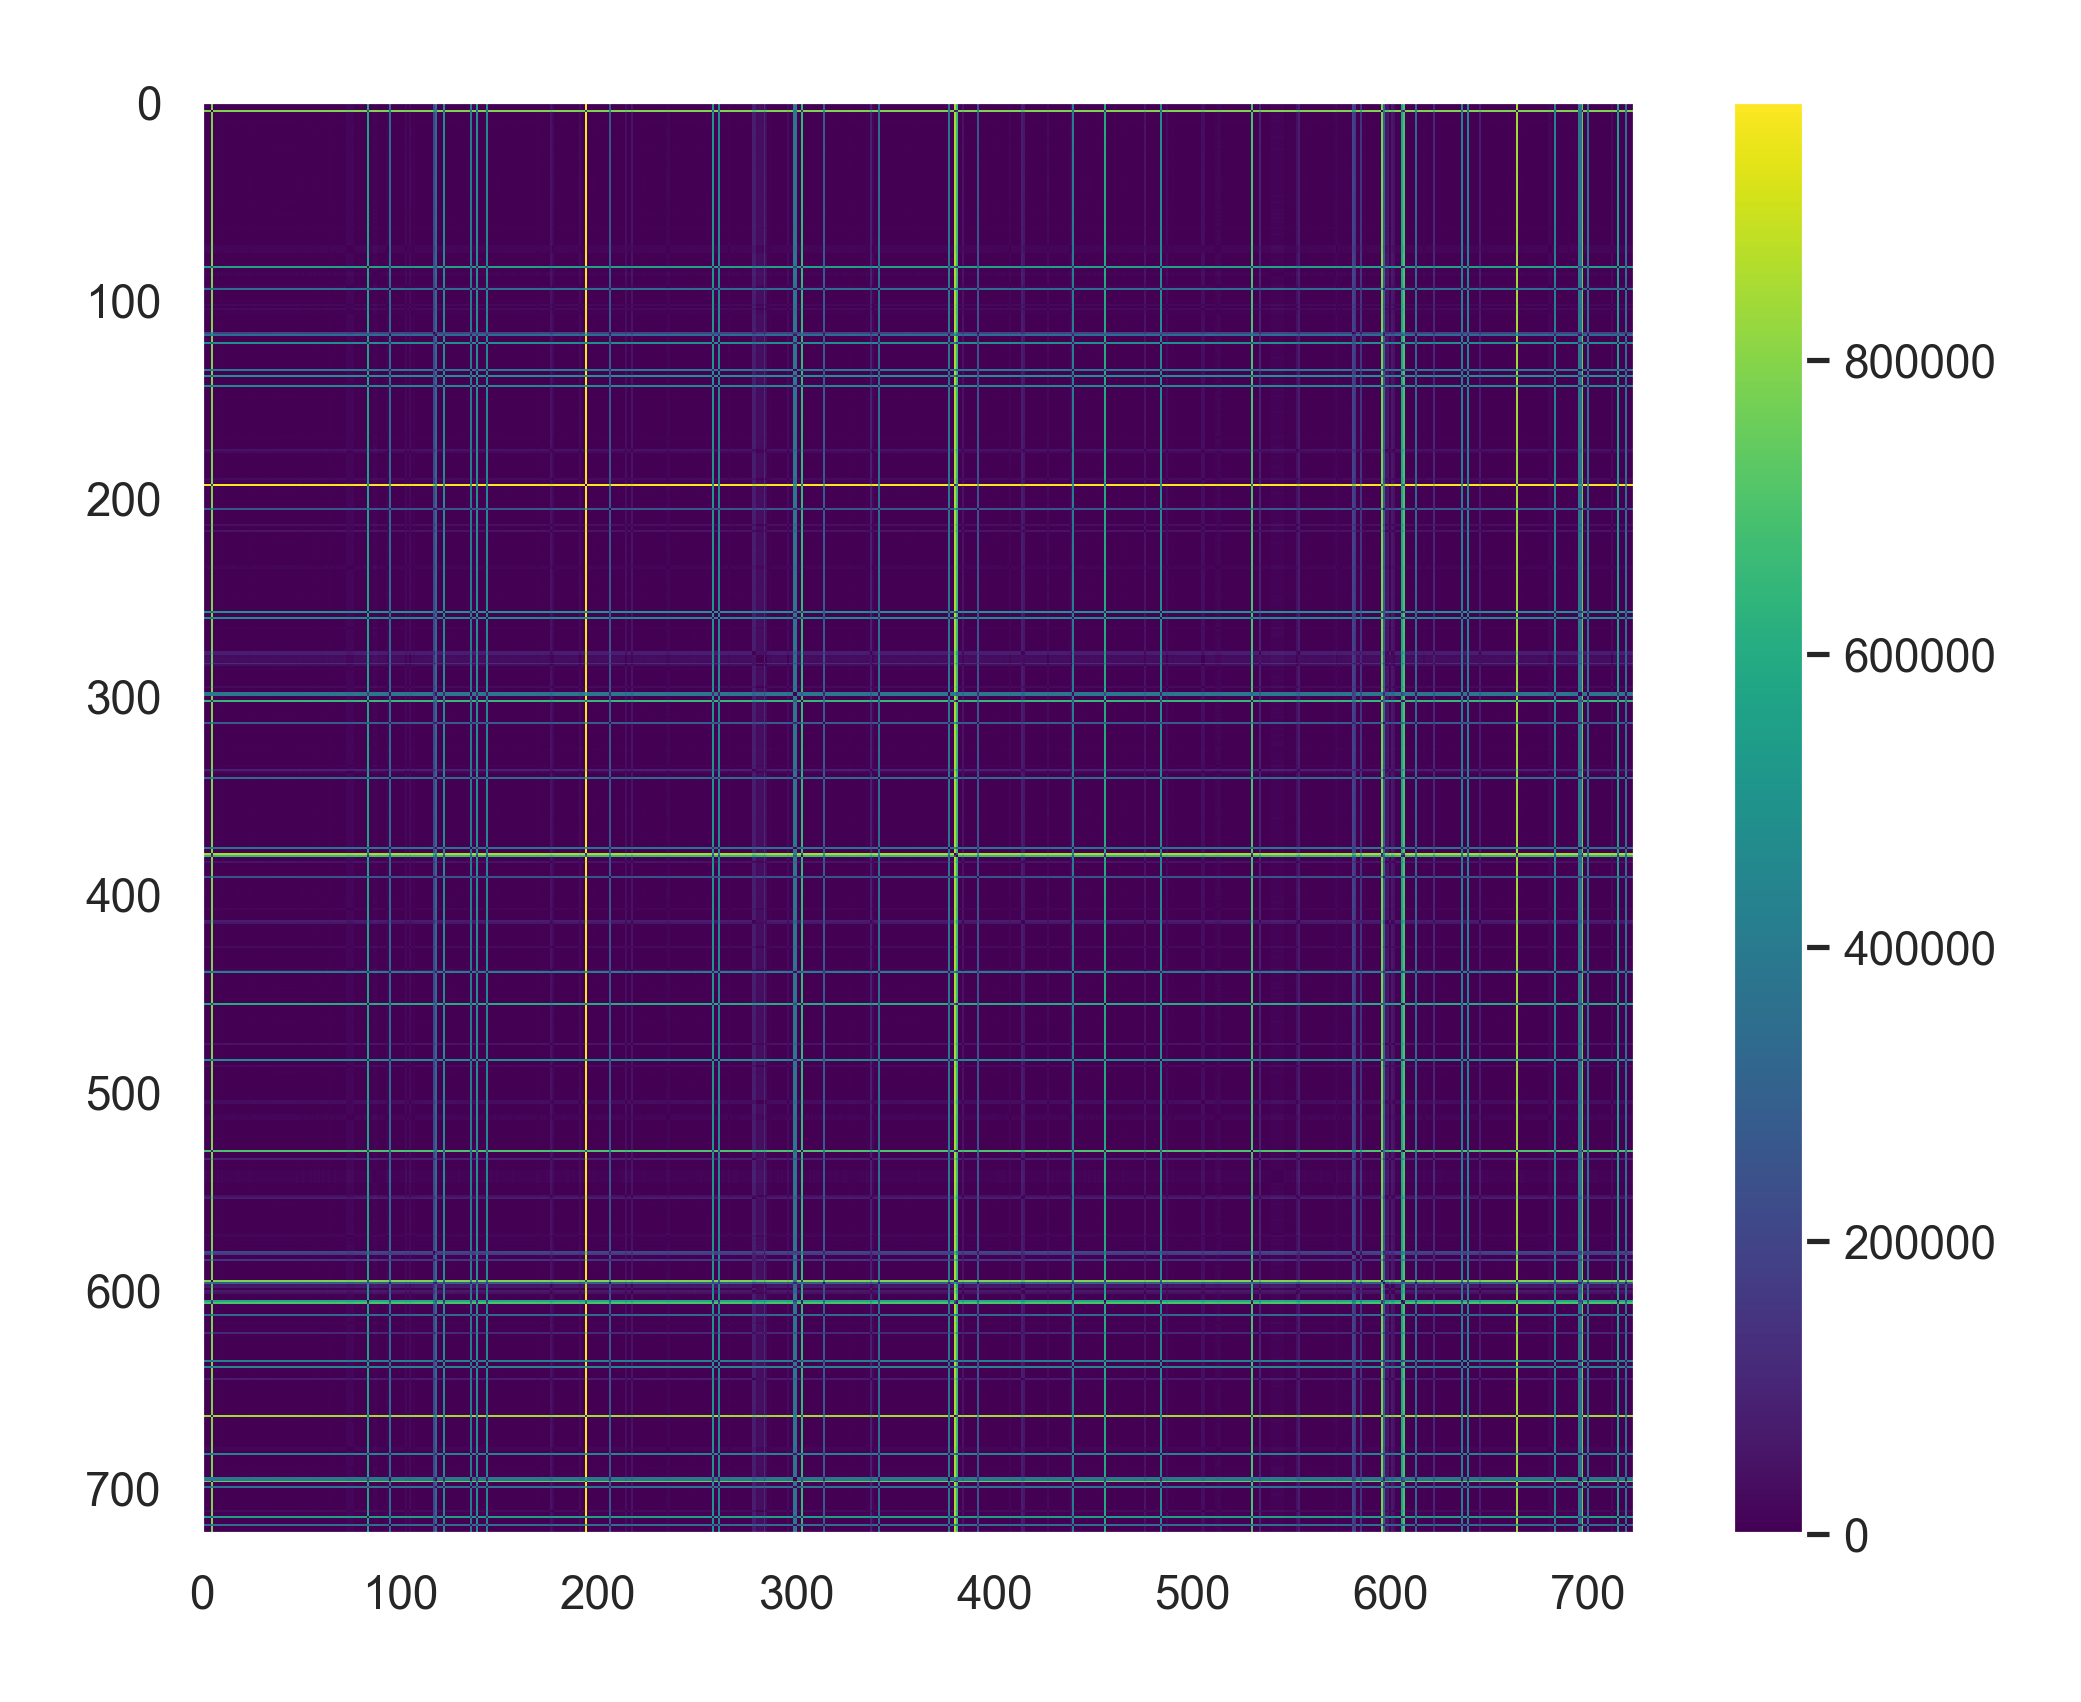

In [84]:
plt.imshow(K_len, cmap='viridis', interpolation='nearest')
plt.grid(False)
plt.colorbar()

/var/folders/b_/mrq467b11bv_32fb0lz46bgm0000gp/T/ipykernel_92503/3329506516.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


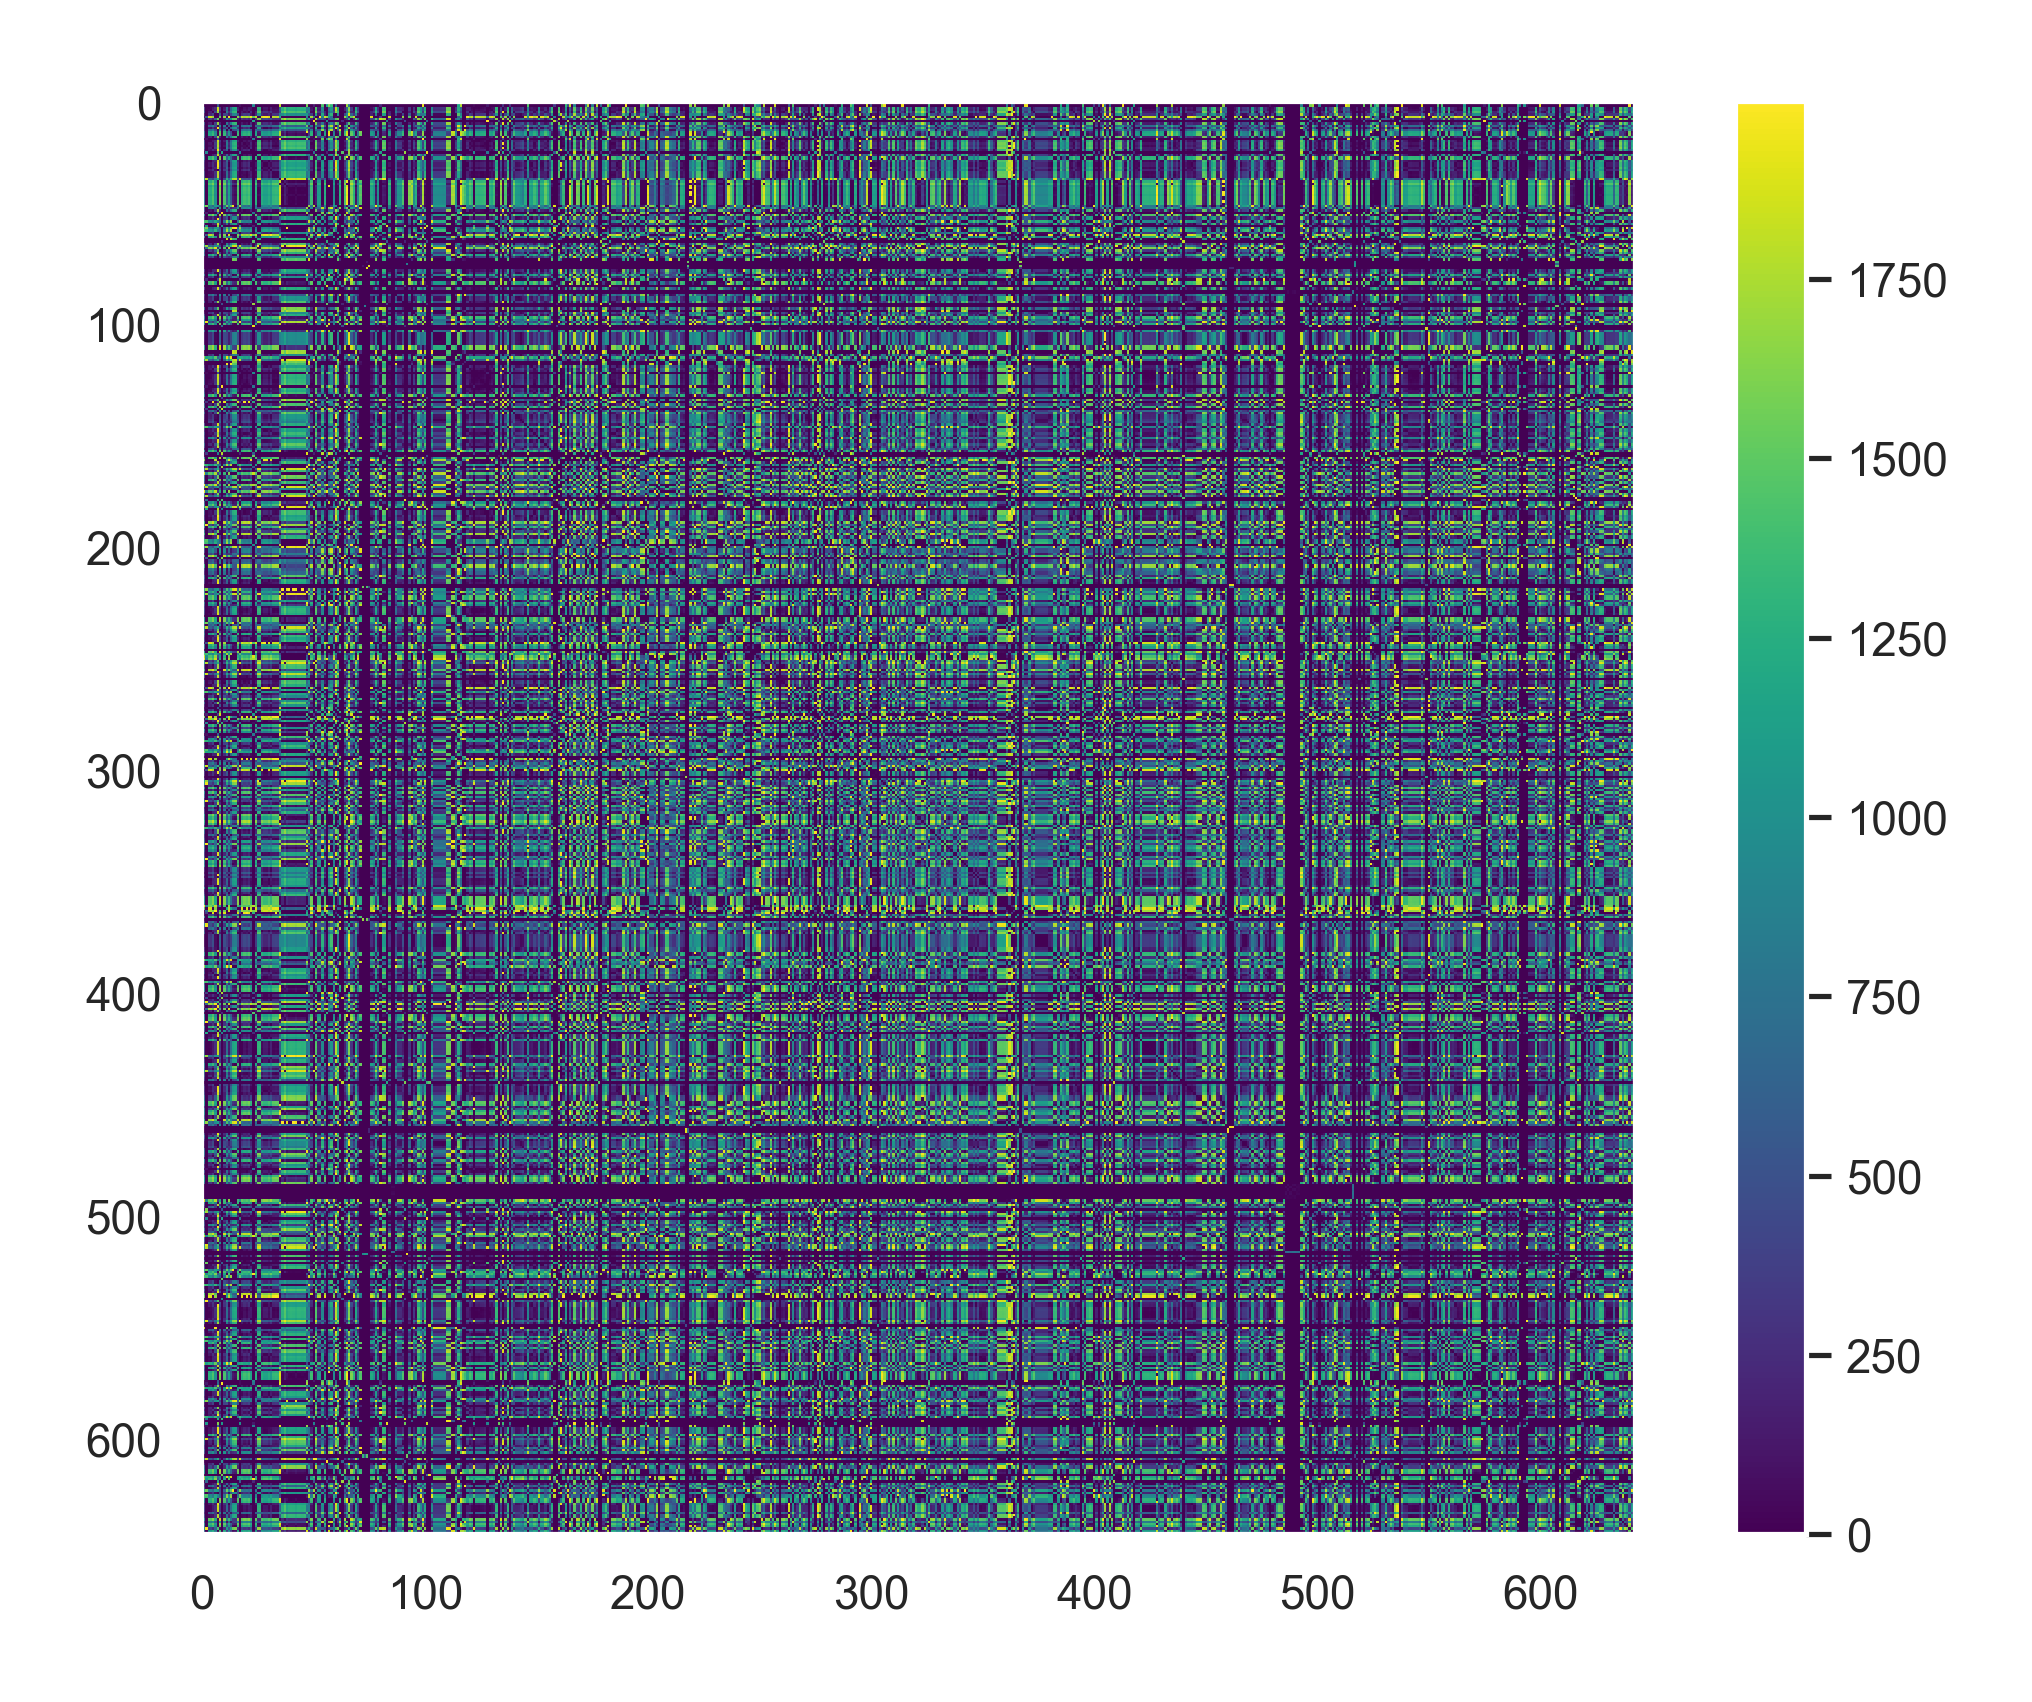

In [97]:
a = K_len.copy()
b = K_lev.copy()
b[b == 0] = np.nan
b[b > 20_000] = np.nan
idx = []
for i in range(len(b)):
    if not np.isnan(b[i]).all():
        idx.append(i)
a[np.isnan(b)] = 0    # maybe set to black rather than 0-color.
plt.imshow(a[idx][:, idx], cmap='viridis', interpolation='nearest')
plt.grid(False)
plt.colorbar()

/var/folders/b_/mrq467b11bv_32fb0lz46bgm0000gp/T/ipykernel_92503/3306544225.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


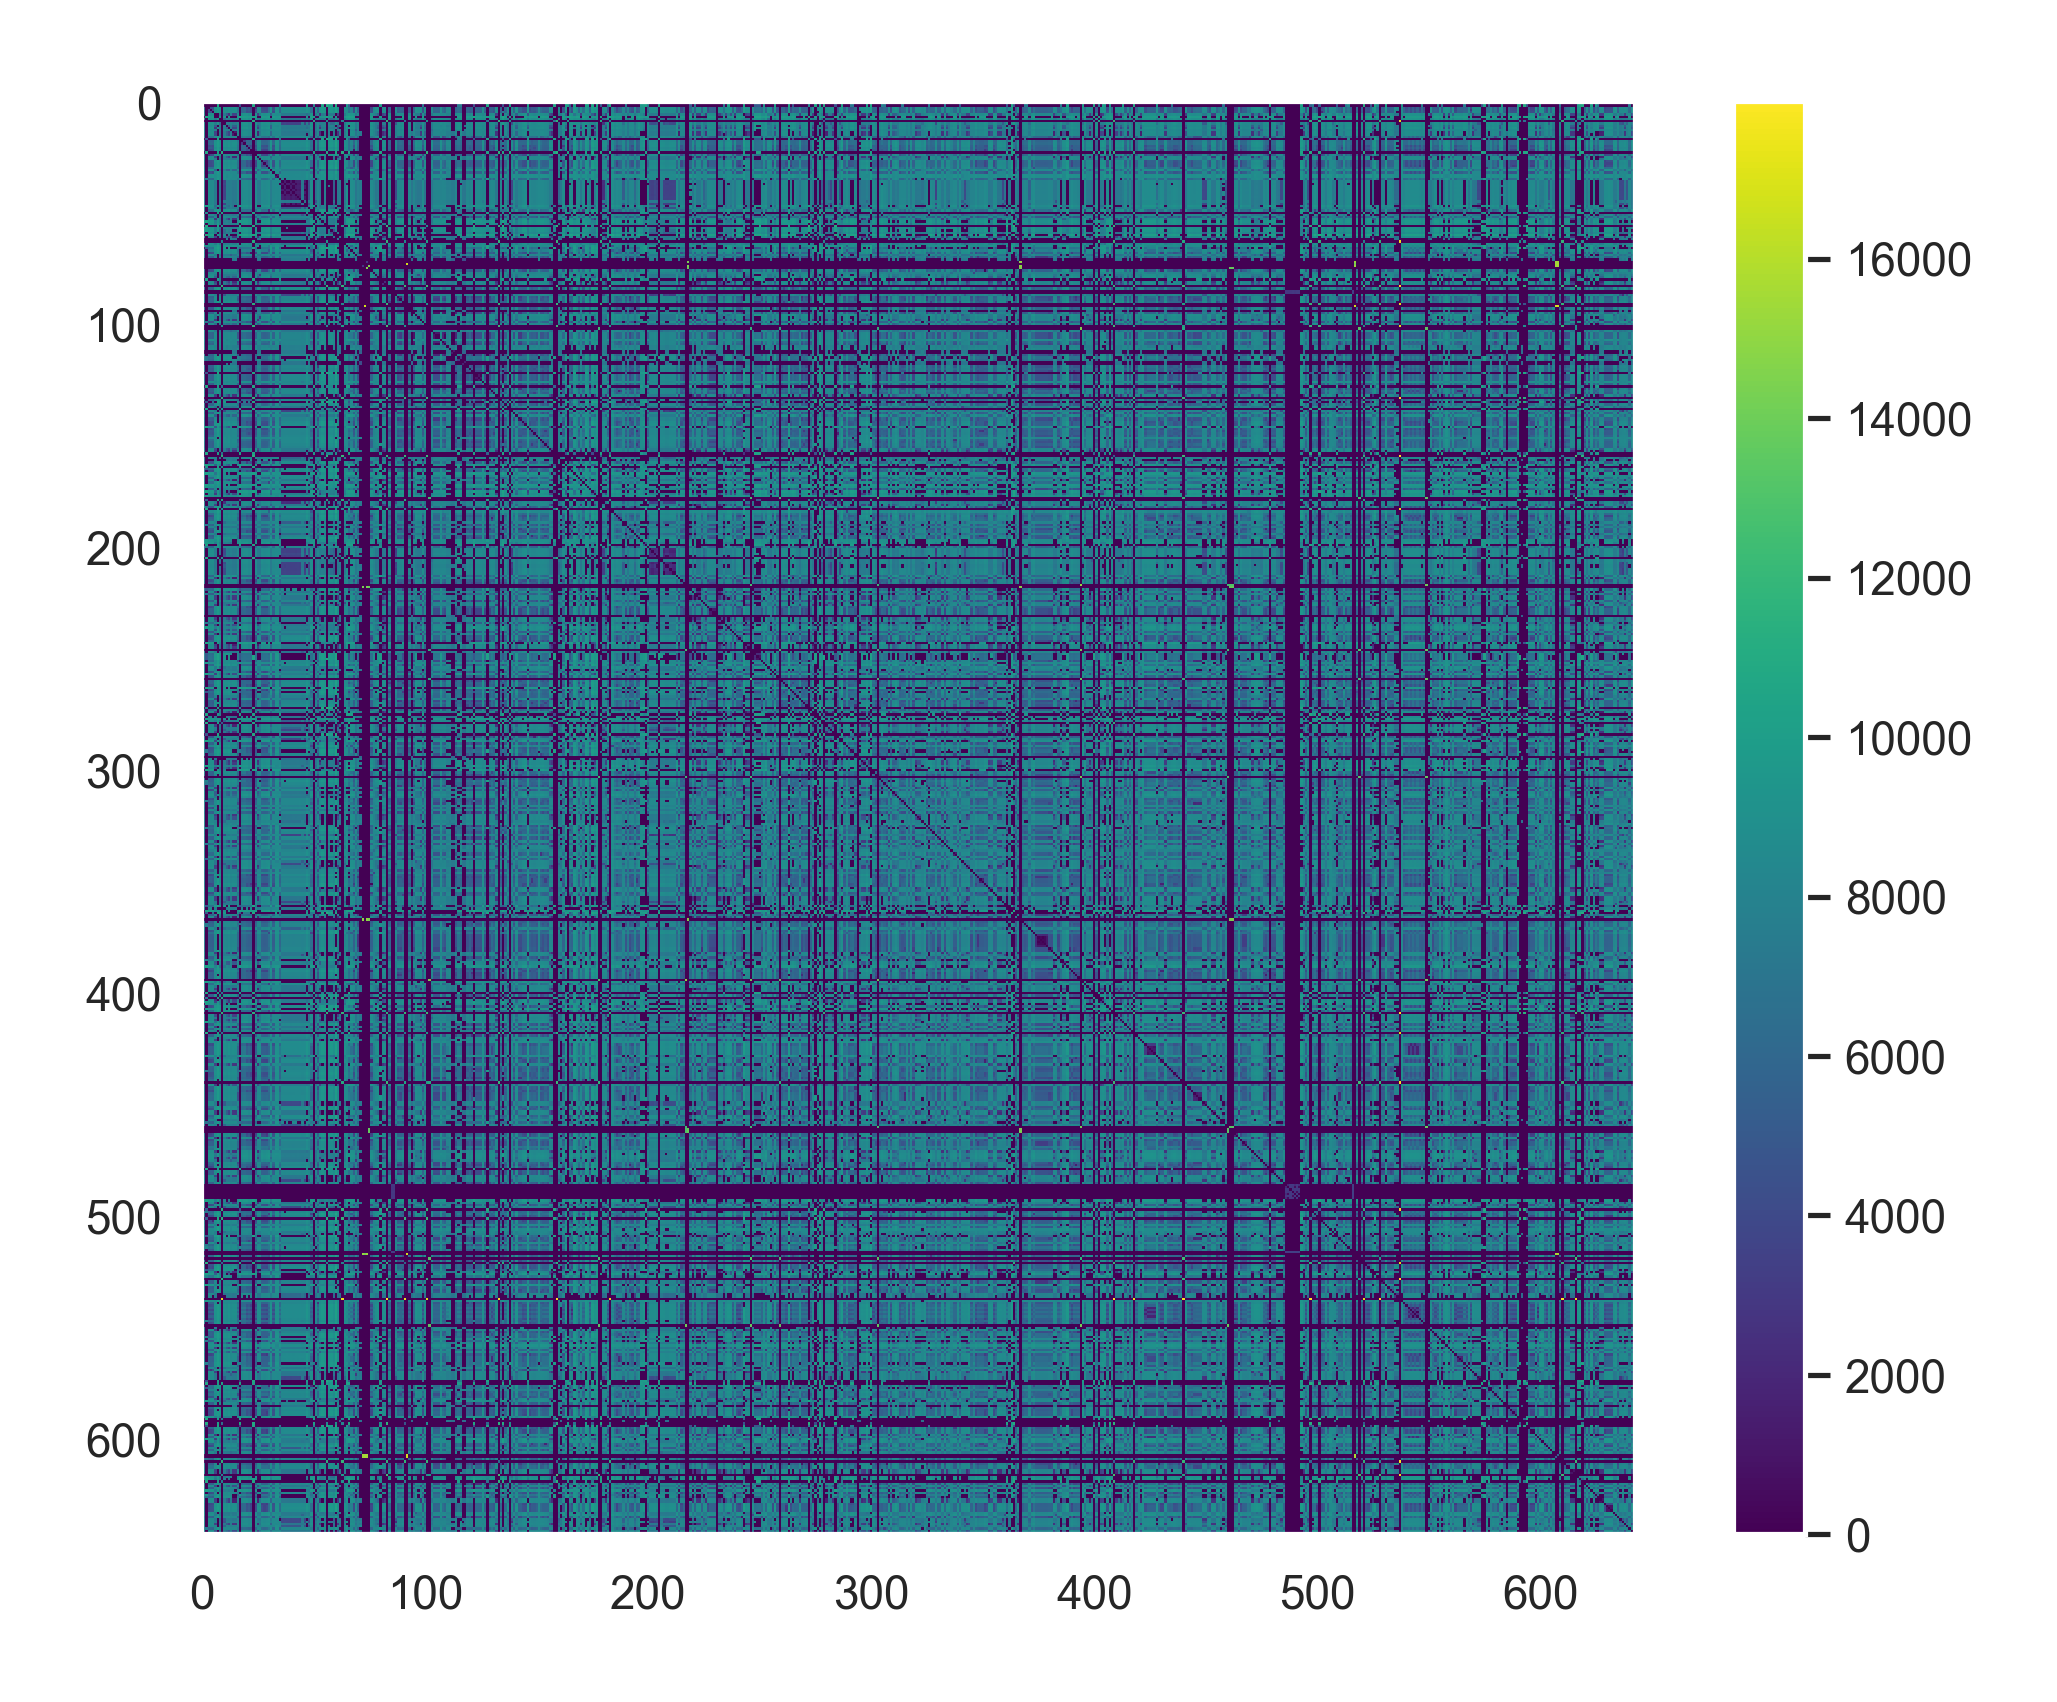

In [98]:
b = K_lev.copy()
b[b == 0] = np.nan
b[b > 20_000] = np.nan
idx = []
for i in range(len(b)):
    if not np.isnan(b[i]).all():
        idx.append(i)
b[np.isnan(b)] = 0
plt.imshow(b[idx][:, idx], cmap='viridis', interpolation='nearest')
plt.grid(False)
plt.colorbar()

In [101]:
K_full = np.where(~np.isnan(K_lev) & (K_lev < 20_000), K_lev, K_len + 20_000)

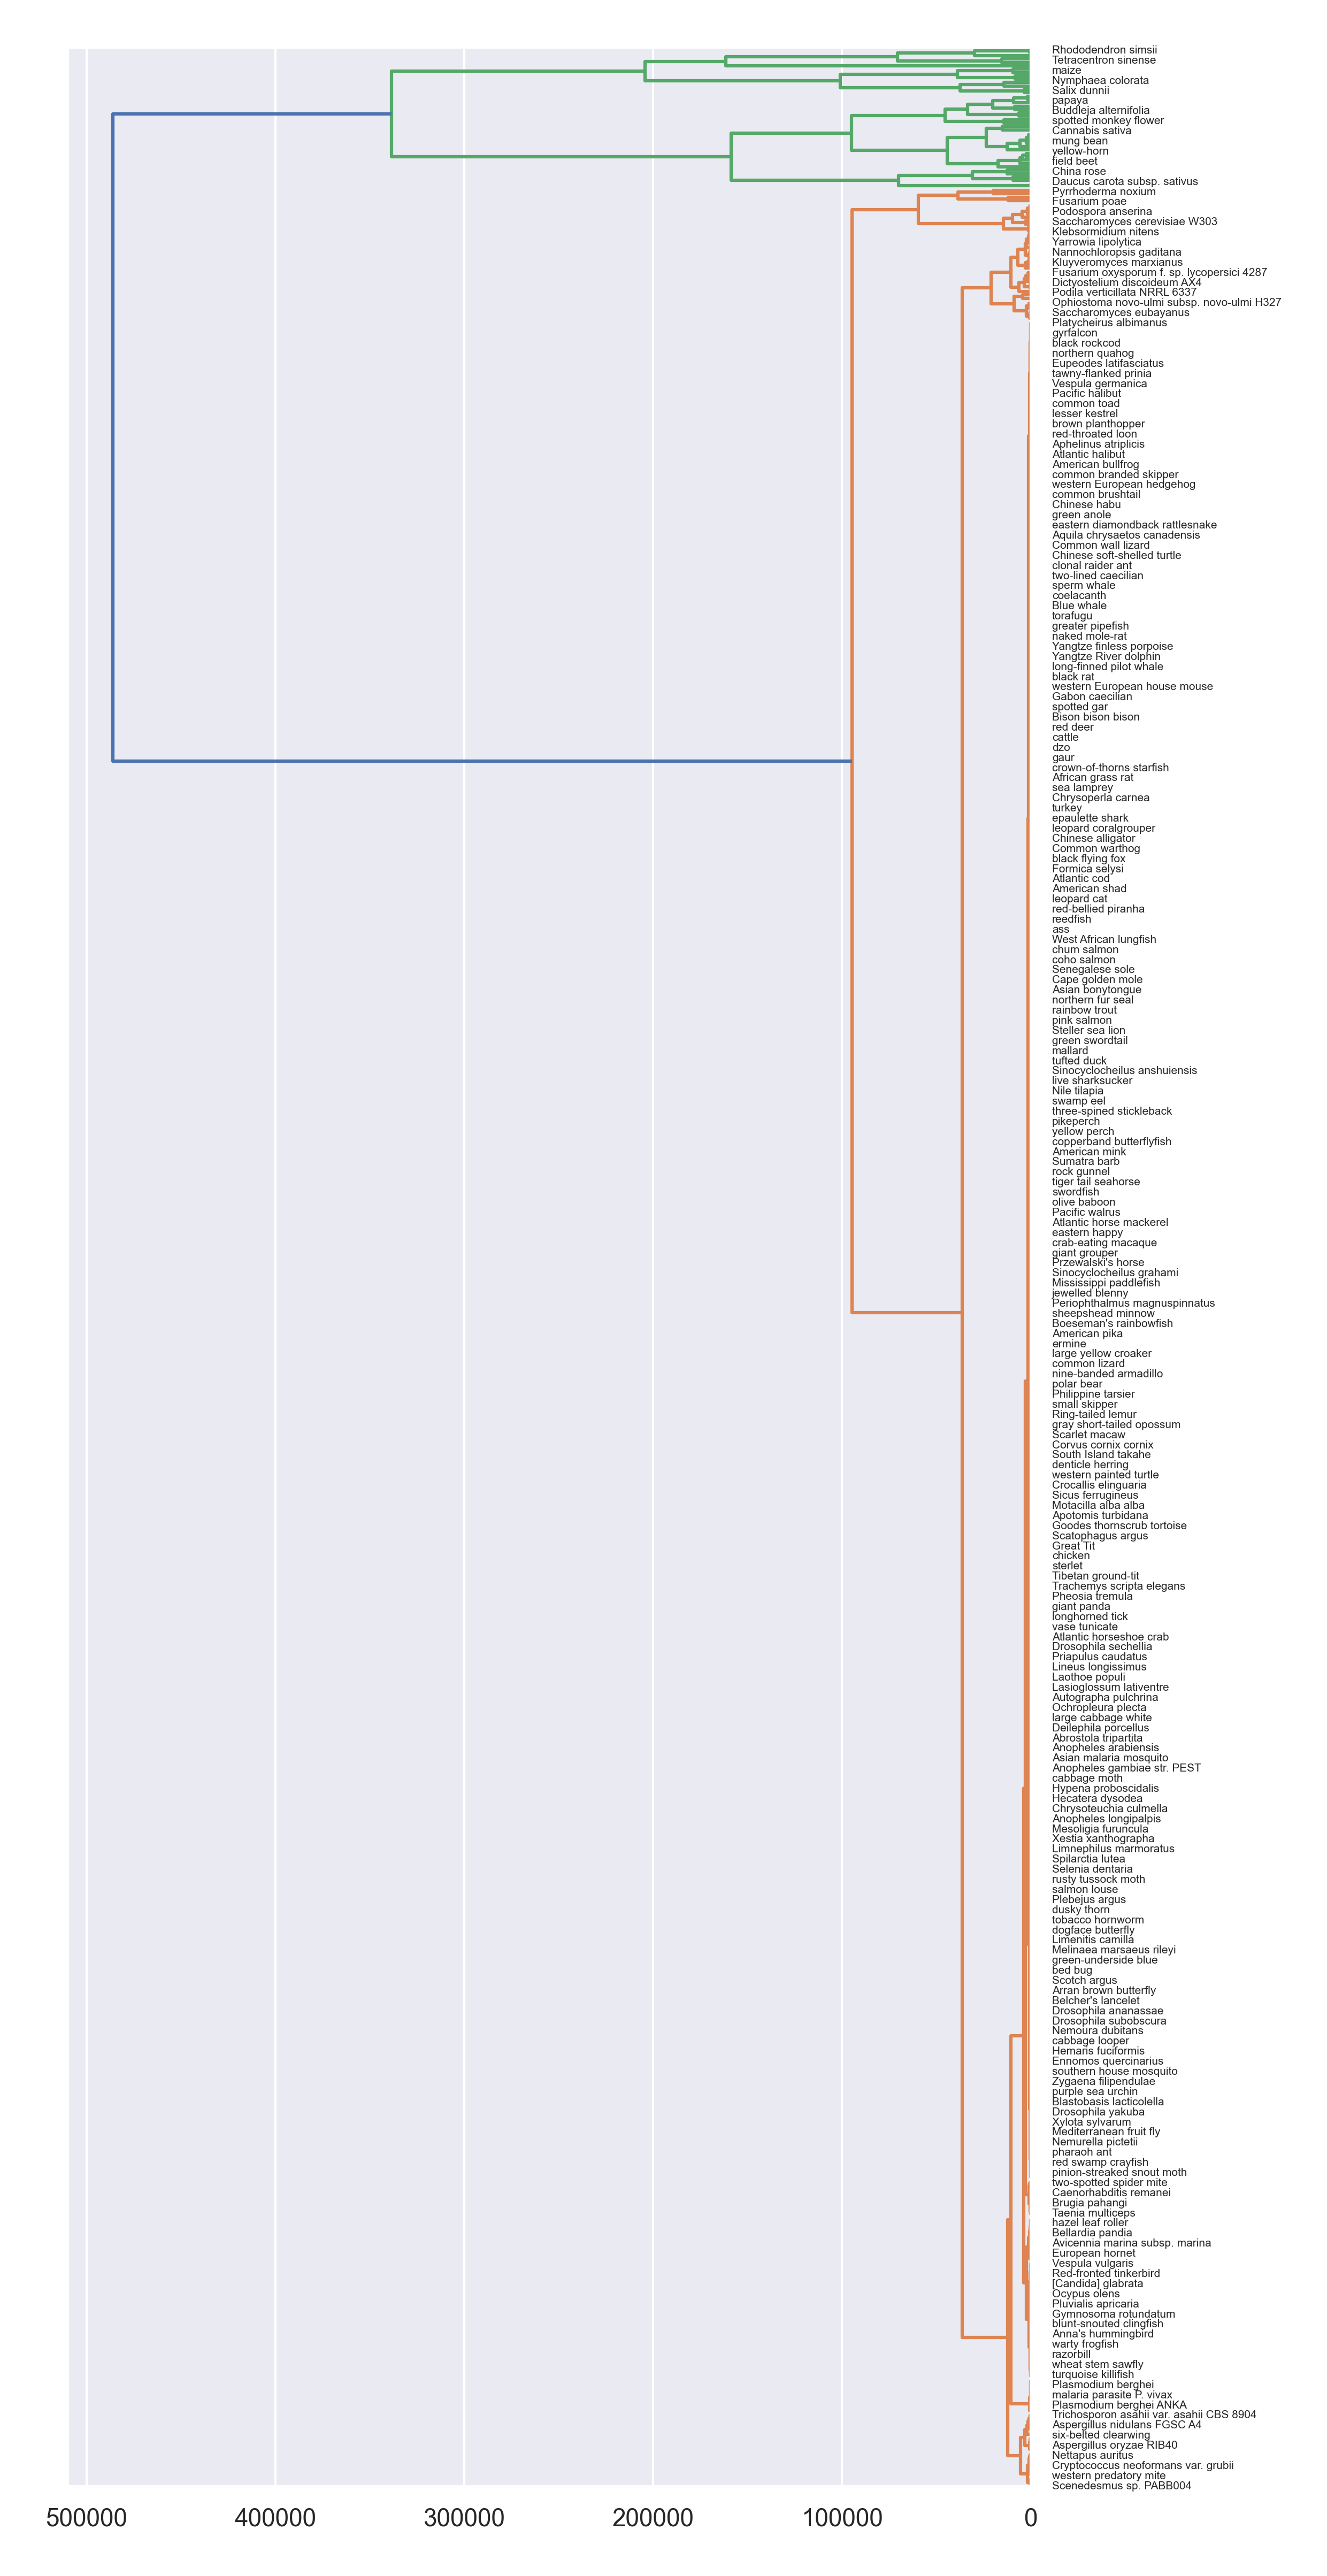

In [104]:
Z = linkage(K_len[np.triu_indices(len(K_len), 1)], 'average')

def llf(x, R):
    """Return label of x if x supposed to be displayed."""
    if R['ivl'].index(str(x)) % 3 == 0:
        return species.name.iloc[x]
    else:
        return ""

fig, ax = plt.subplots(figsize=(W, 2*W))
R = dendrogram(Z, no_plot=True)
R = dendrogram(Z, orientation='left', ax=ax, leaf_label_func=lambda x: llf(x, R))#, labels=species.name.to_list())
ax.yaxis.grid(False)
#ax.set_xscale('log')
plt.show()

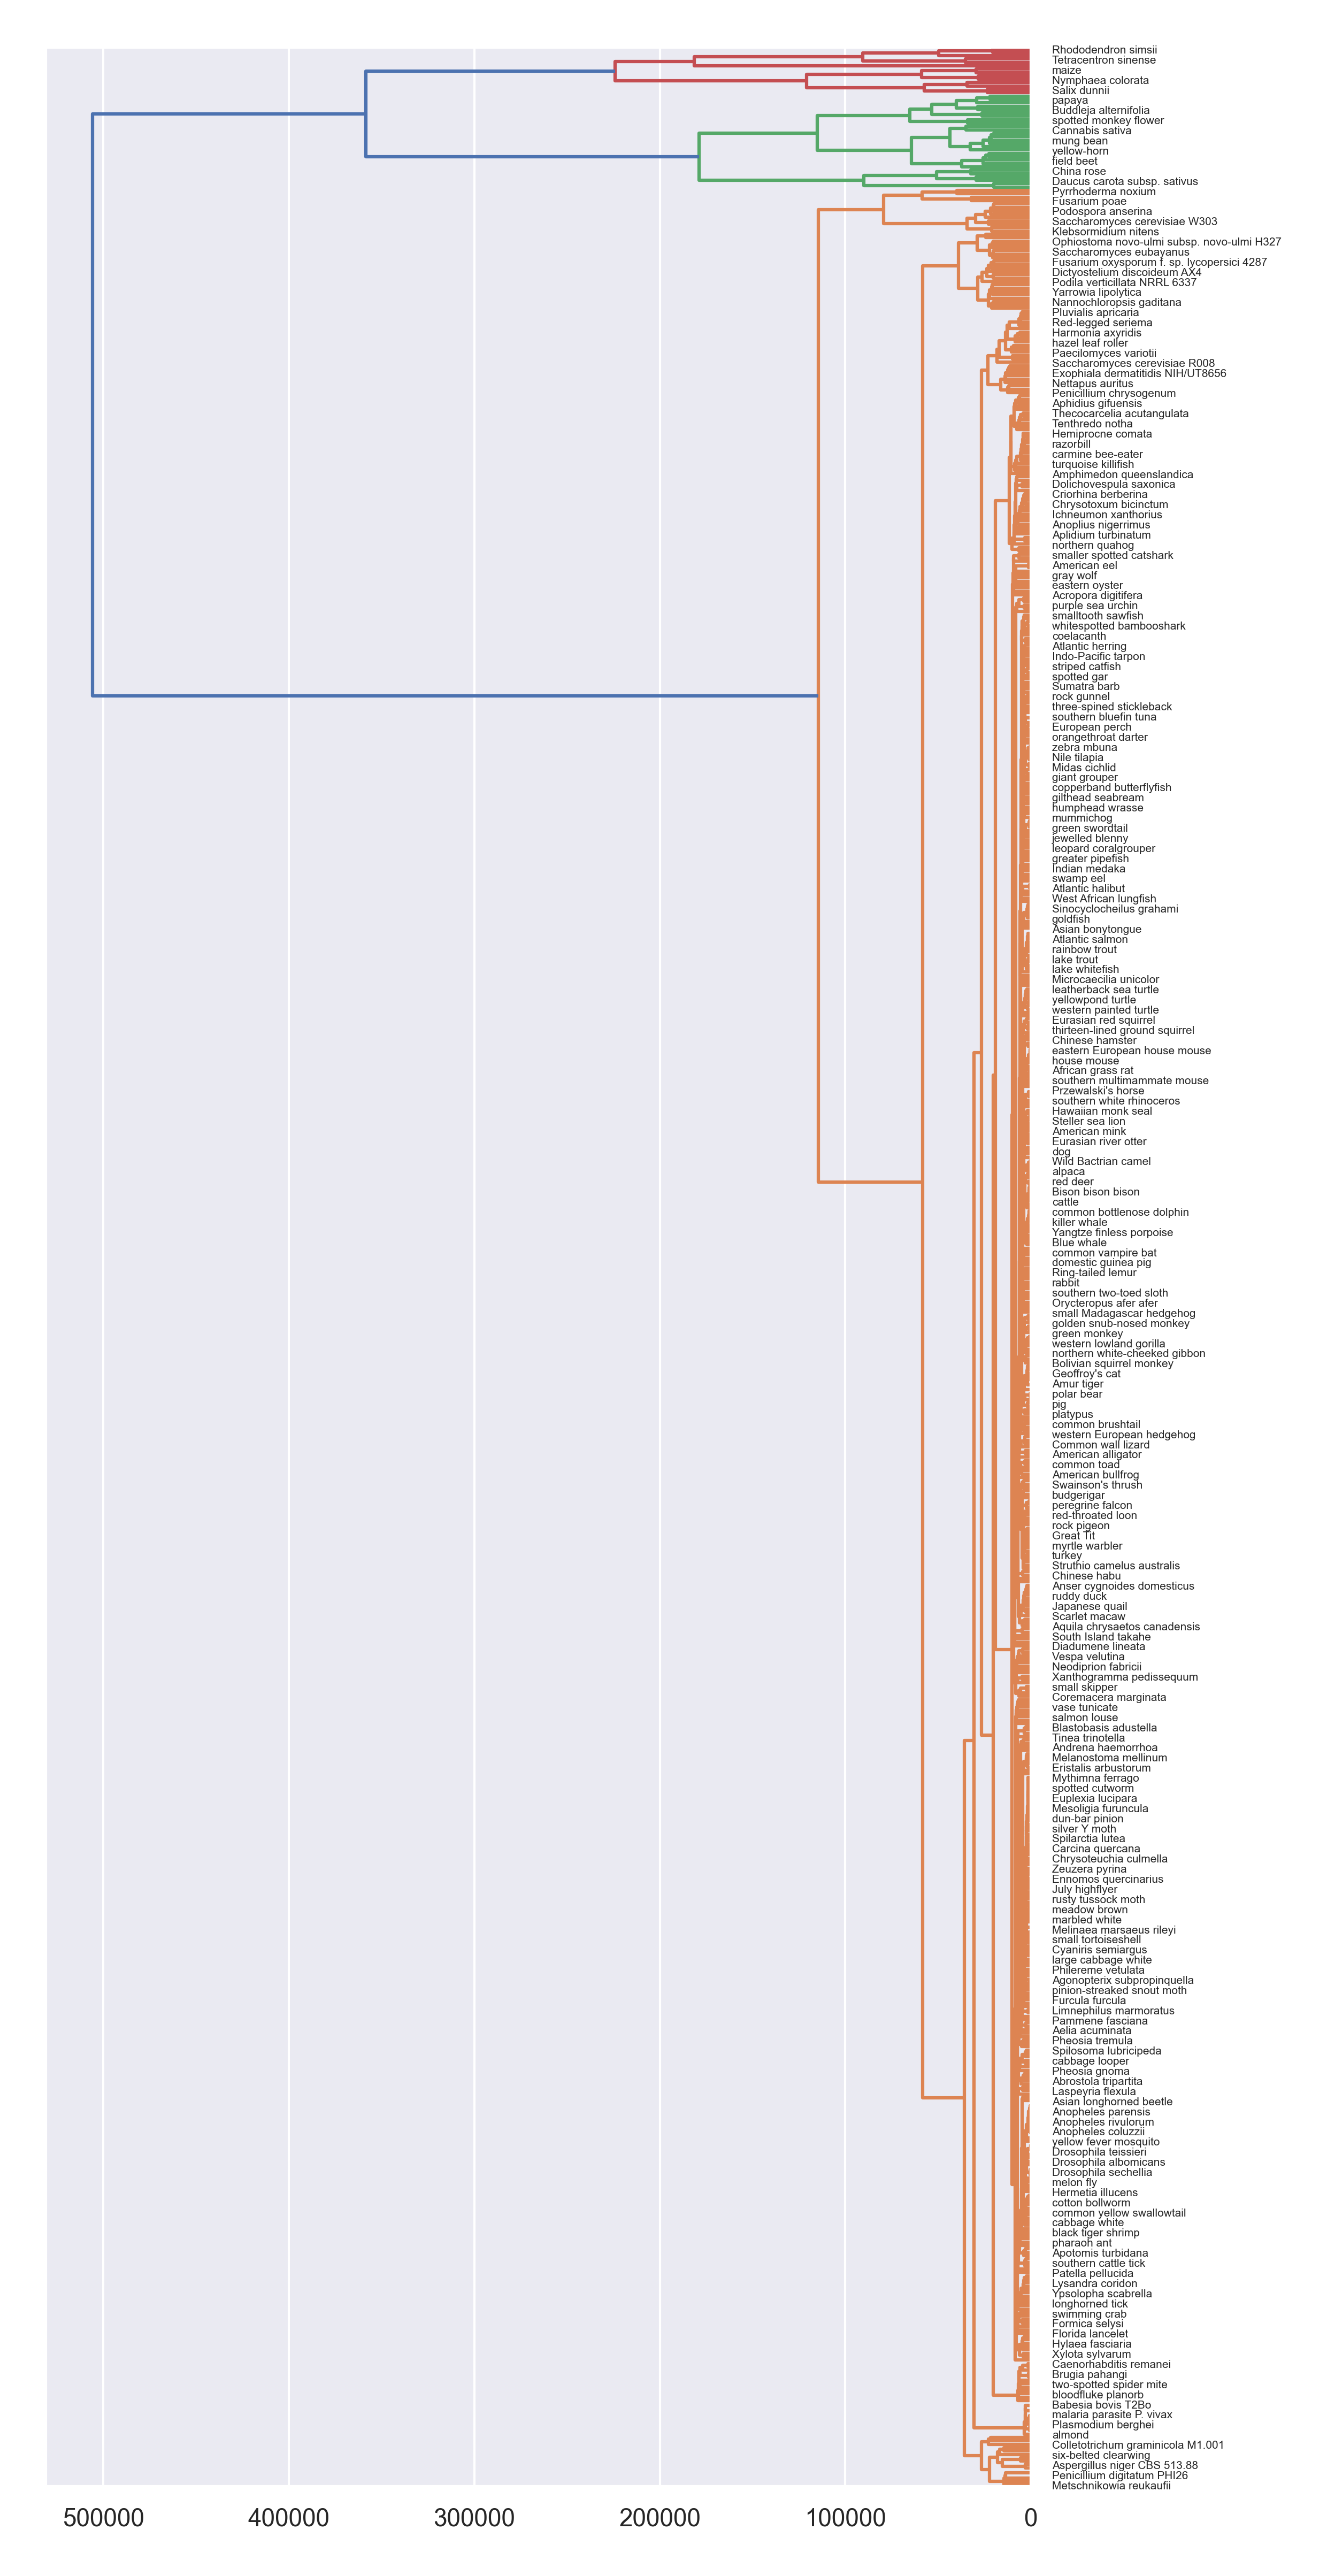

In [105]:
Z = linkage(K_full[np.triu_indices(len(K_full), 1)], 'average')

def llf(x, R):
    """Return label of x if x supposed to be displayed."""
    if R['ivl'].index(str(x)) % 3 == 0:
        return species.name.iloc[x]
    else:
        return ""

fig, ax = plt.subplots(figsize=(W, 2*W))
R = dendrogram(Z, no_plot=True)
R = dendrogram(Z, orientation='left', ax=ax, leaf_label_func=lambda x: llf(x, R))#, labels=species.name.to_list())
ax.yaxis.grid(False)
#ax.set_xscale('log')
plt.show()

---

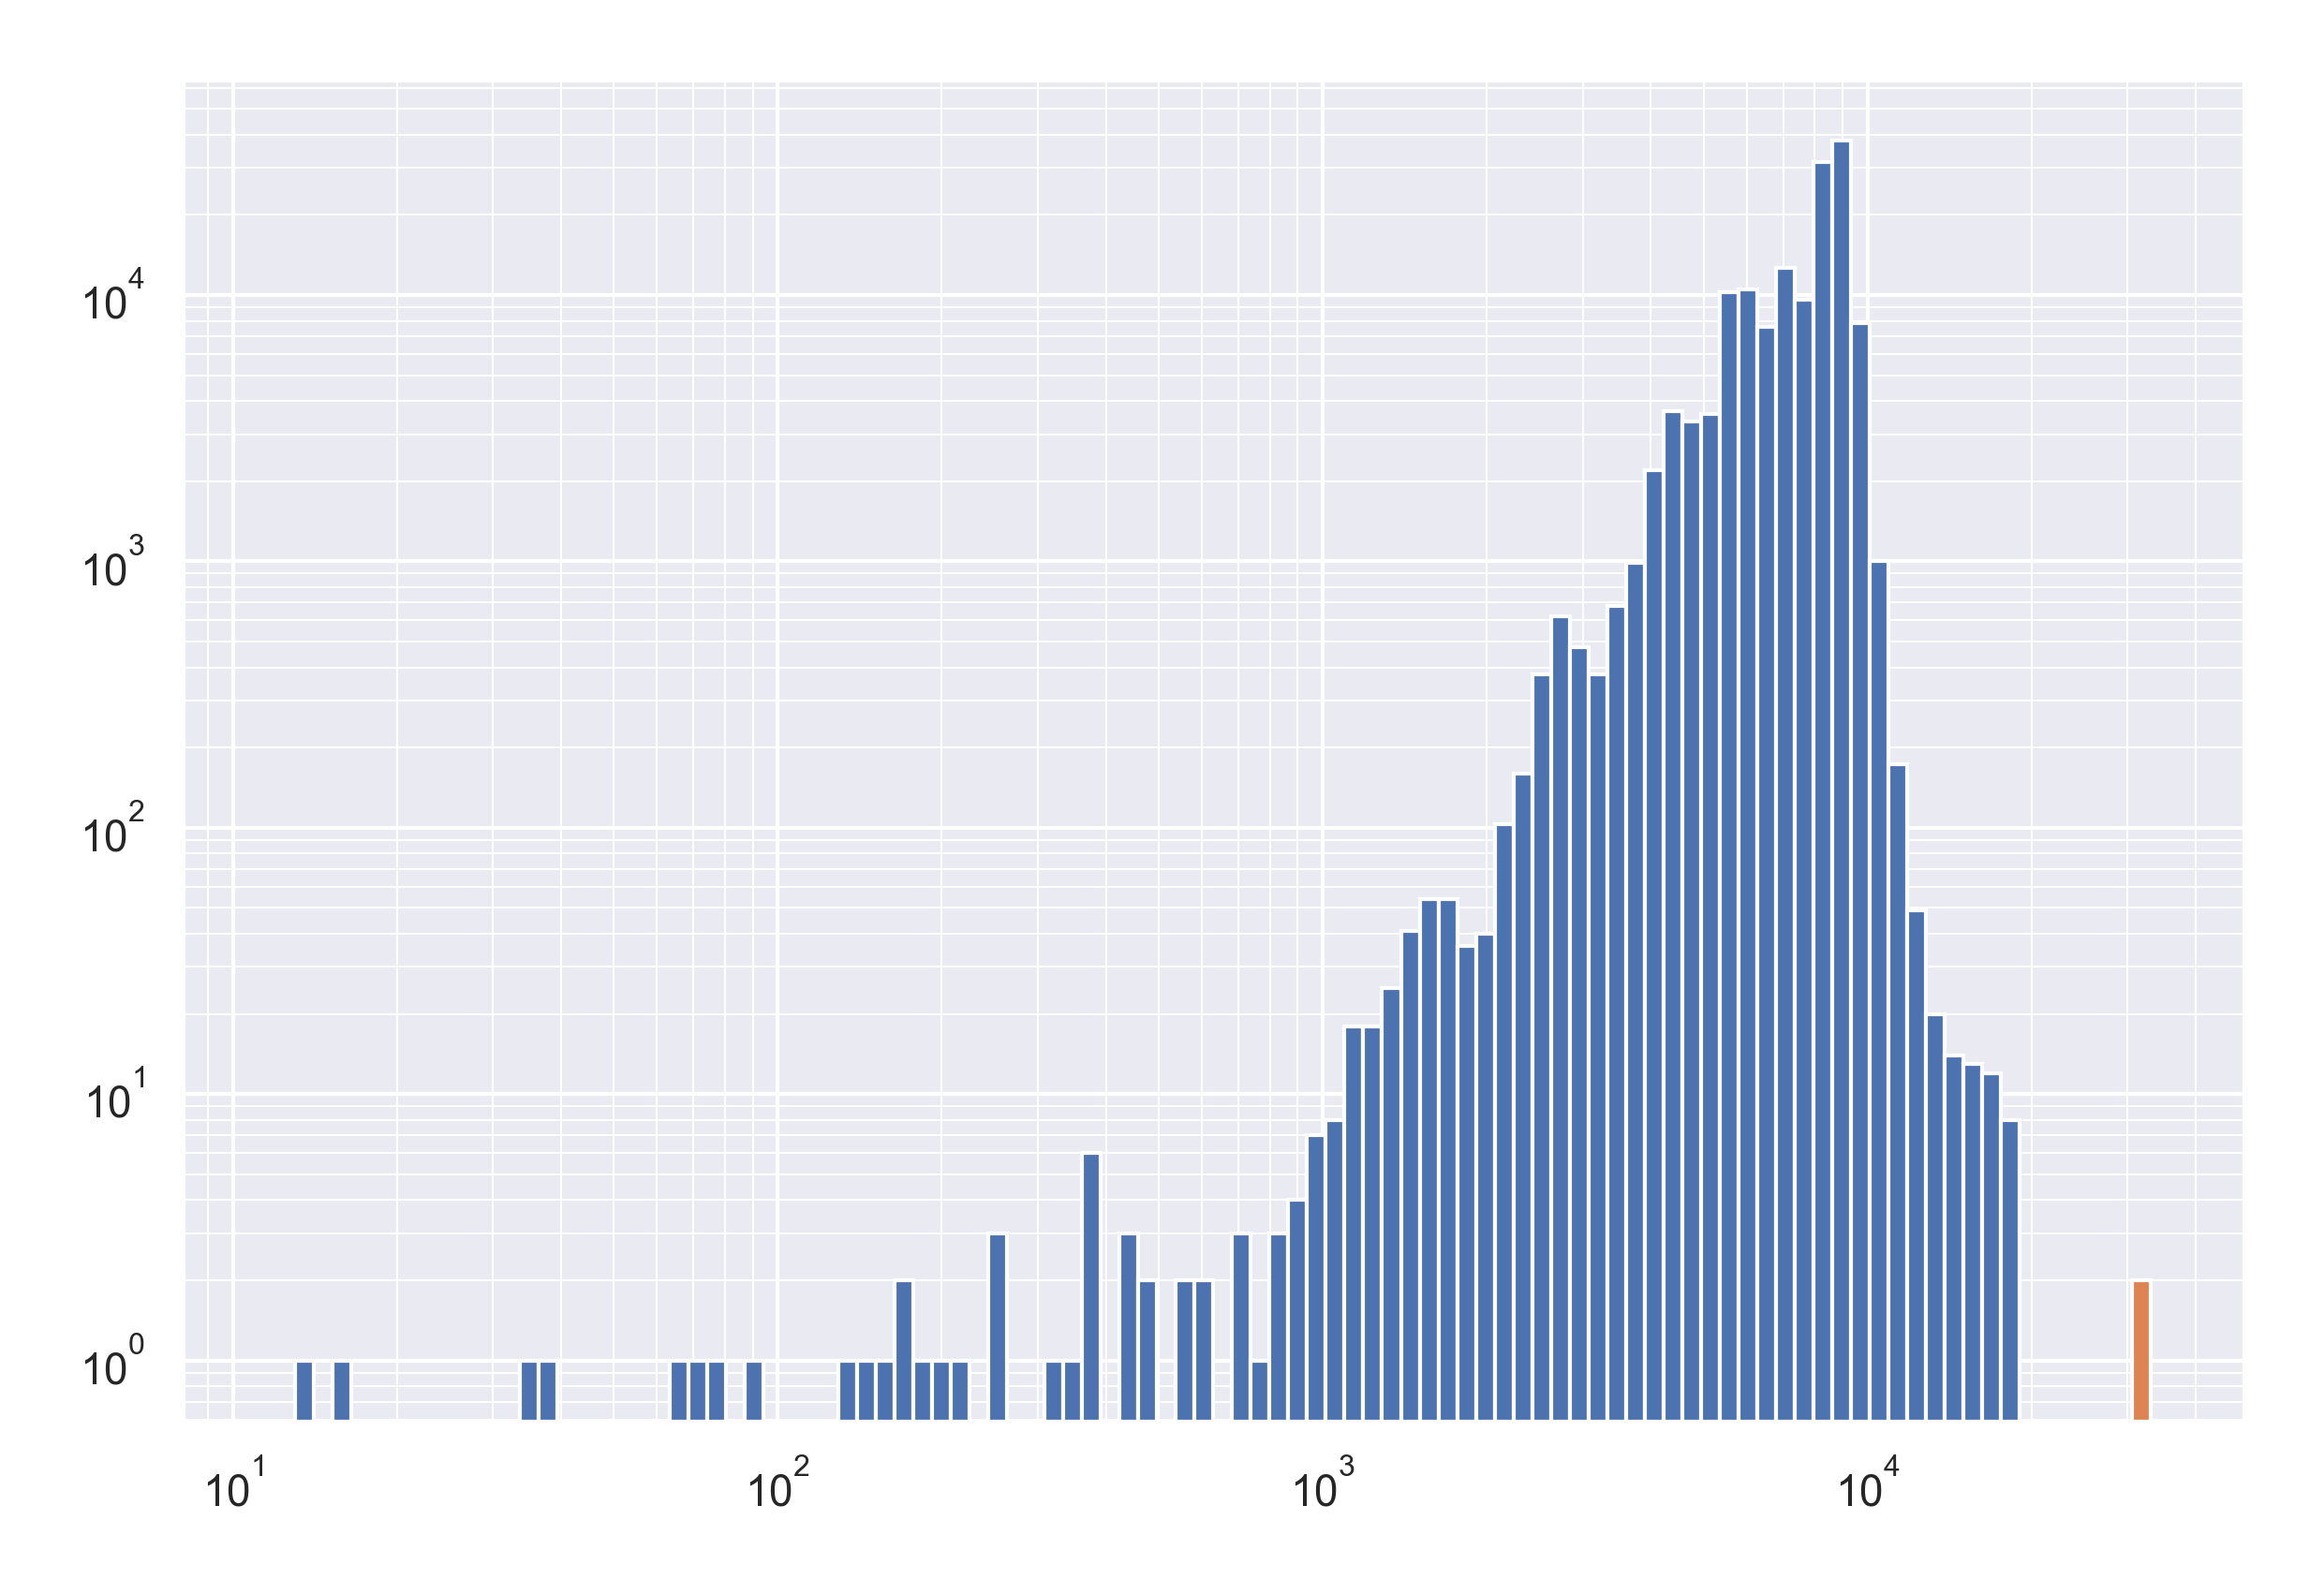

In [71]:
levs = K_lev[np.triu_indices(len(K_lev), 1)]
levs = levs[levs > 0]
hist, bins, _ = plt.hist(levs, 100)
plt.close()

fig, ax = plt.subplots()
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax.hist(levs[levs < 20_000], bins=logbins)
ax.hist(levs[levs >= 20_000], bins=logbins)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.grid(which='minor', lw=0.5)
ax.yaxis.grid(which='minor', lw=0.5)
plt.show()

/var/folders/b_/mrq467b11bv_32fb0lz46bgm0000gp/T/ipykernel_92503/2820616904.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


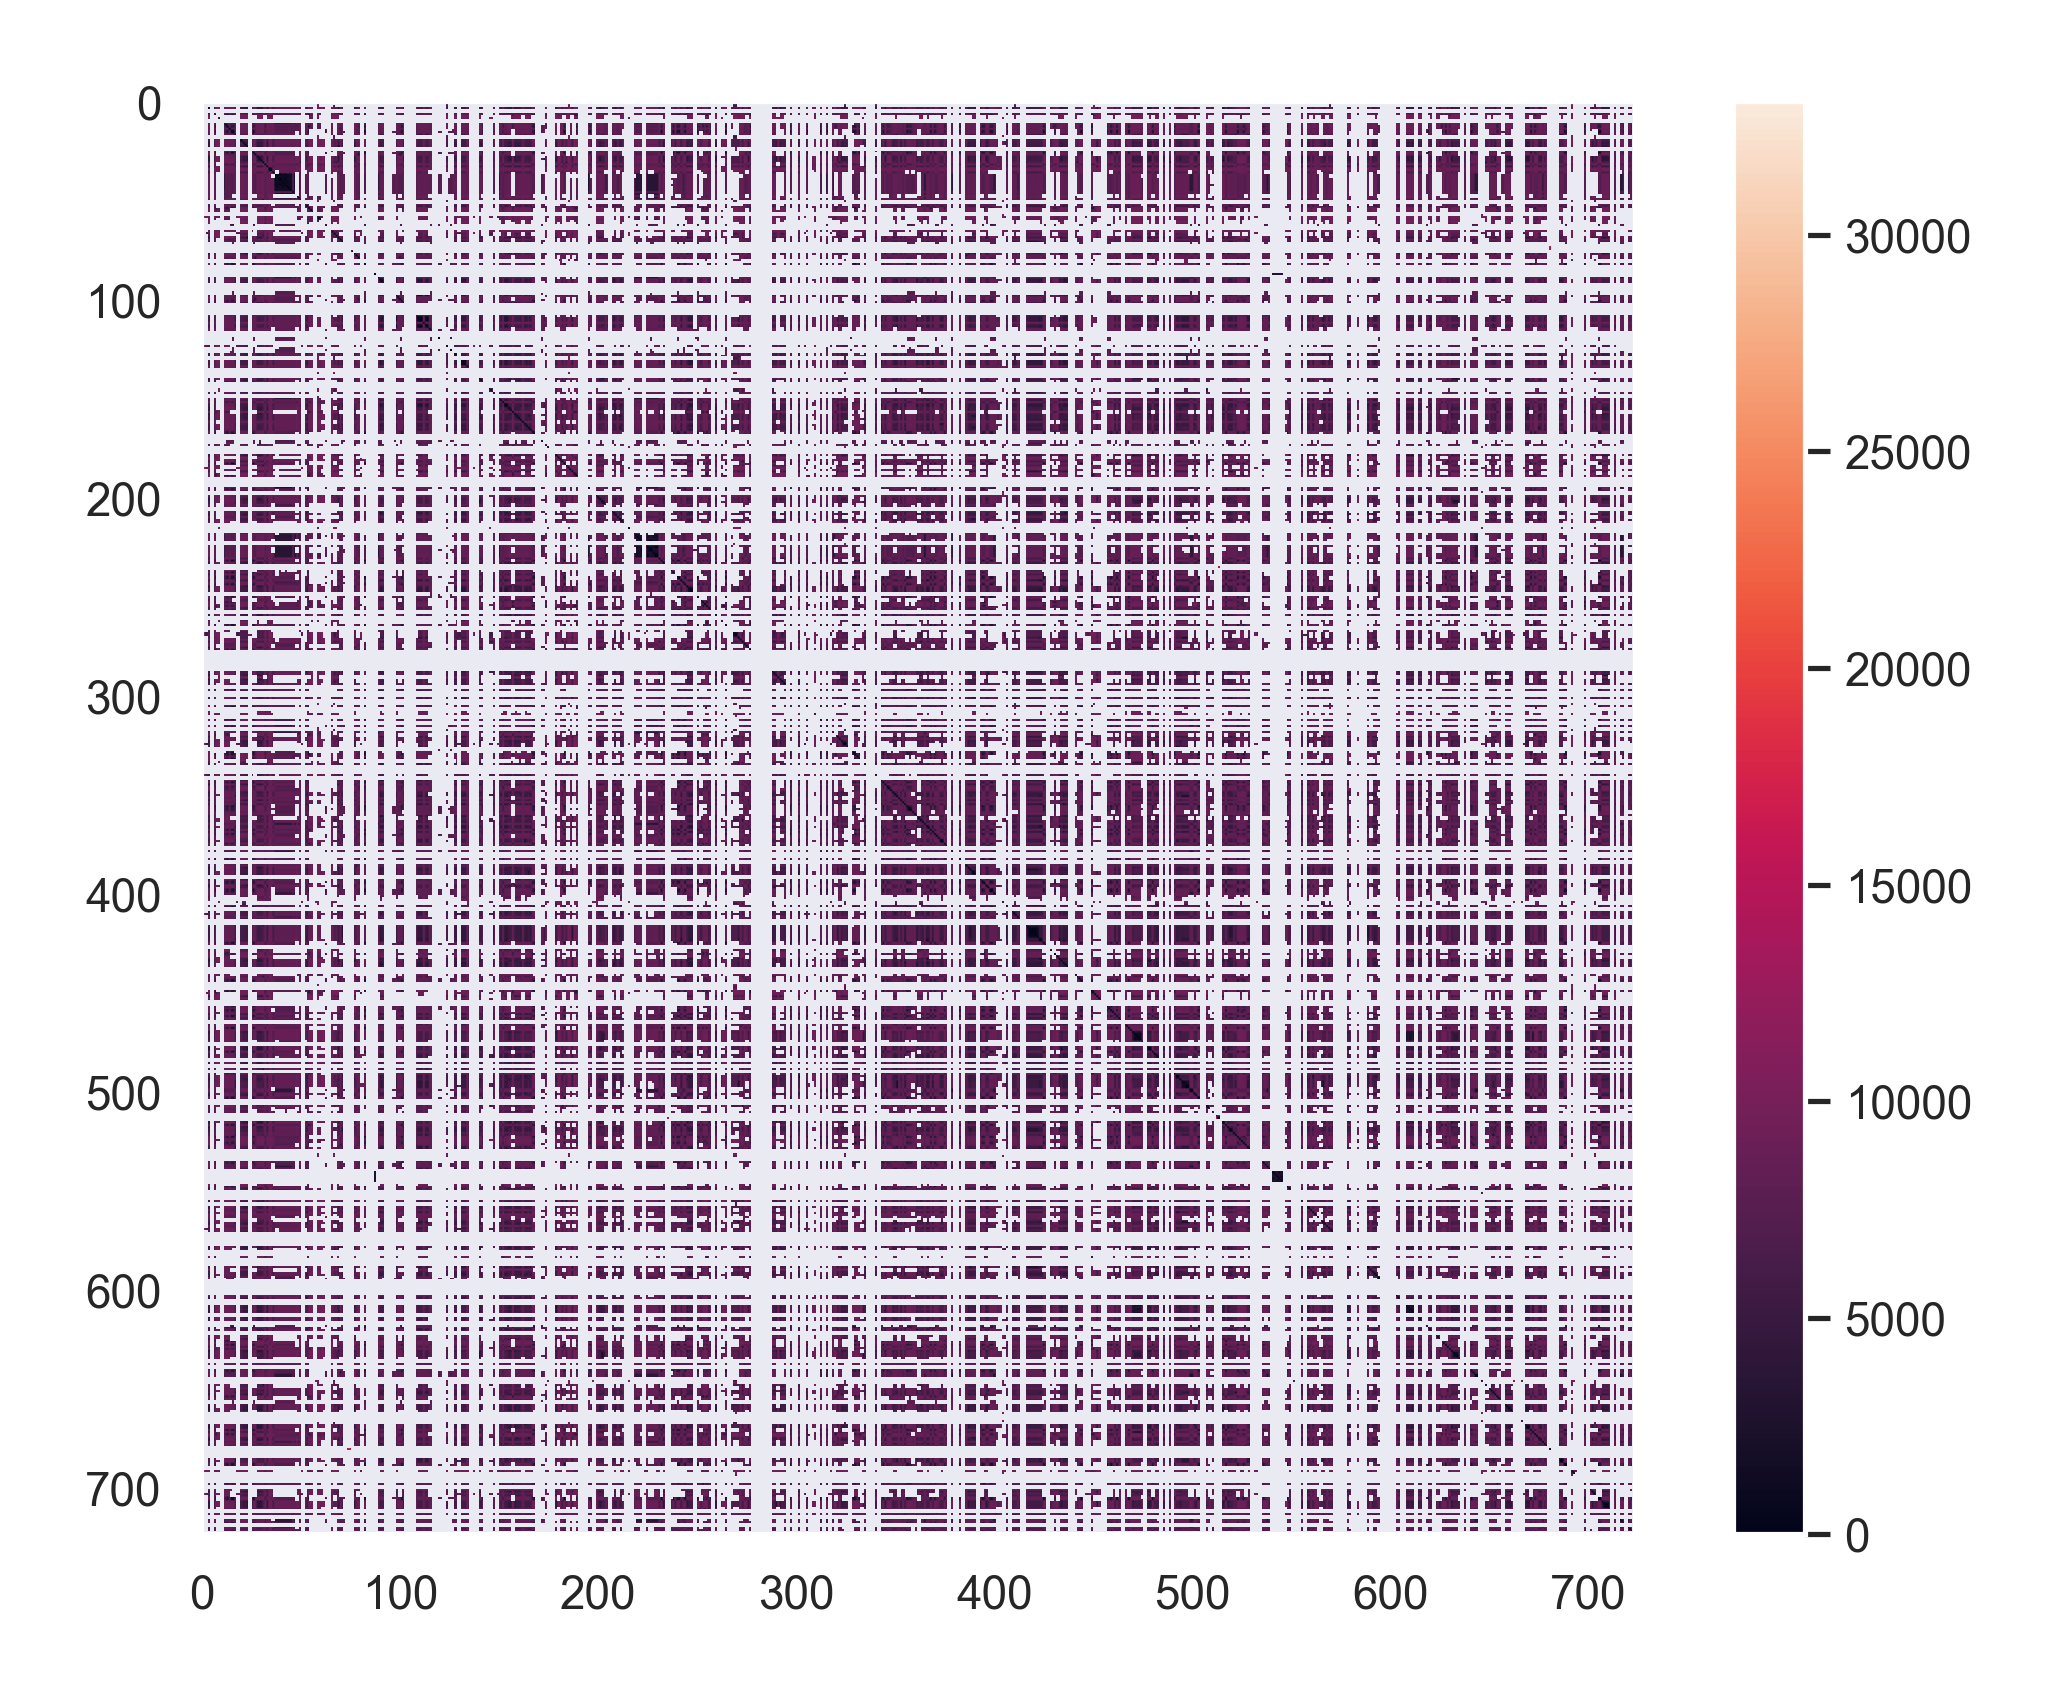

In [44]:
plt.imshow(a)
plt.grid(False)
plt.colorbar()

In [ ]:
# Save matrices
np.save('../dat/K_len.npy', K_len)
np.save('../dat/K_lev.npy', K_lev)

In [17]:
# Check lengths of dna sequences with len-distance < 2000
lens = []
for i in trange(5, len(species)):
    a = species.dna[i]
    for j in range(i, len(species)):
        b = species.dna[j]
        if K_len[i, j] < 2000:
            lens.append((len(a) + len(b)) // 2)

  0%|          | 0/719 [00:00<?, ?it/s]

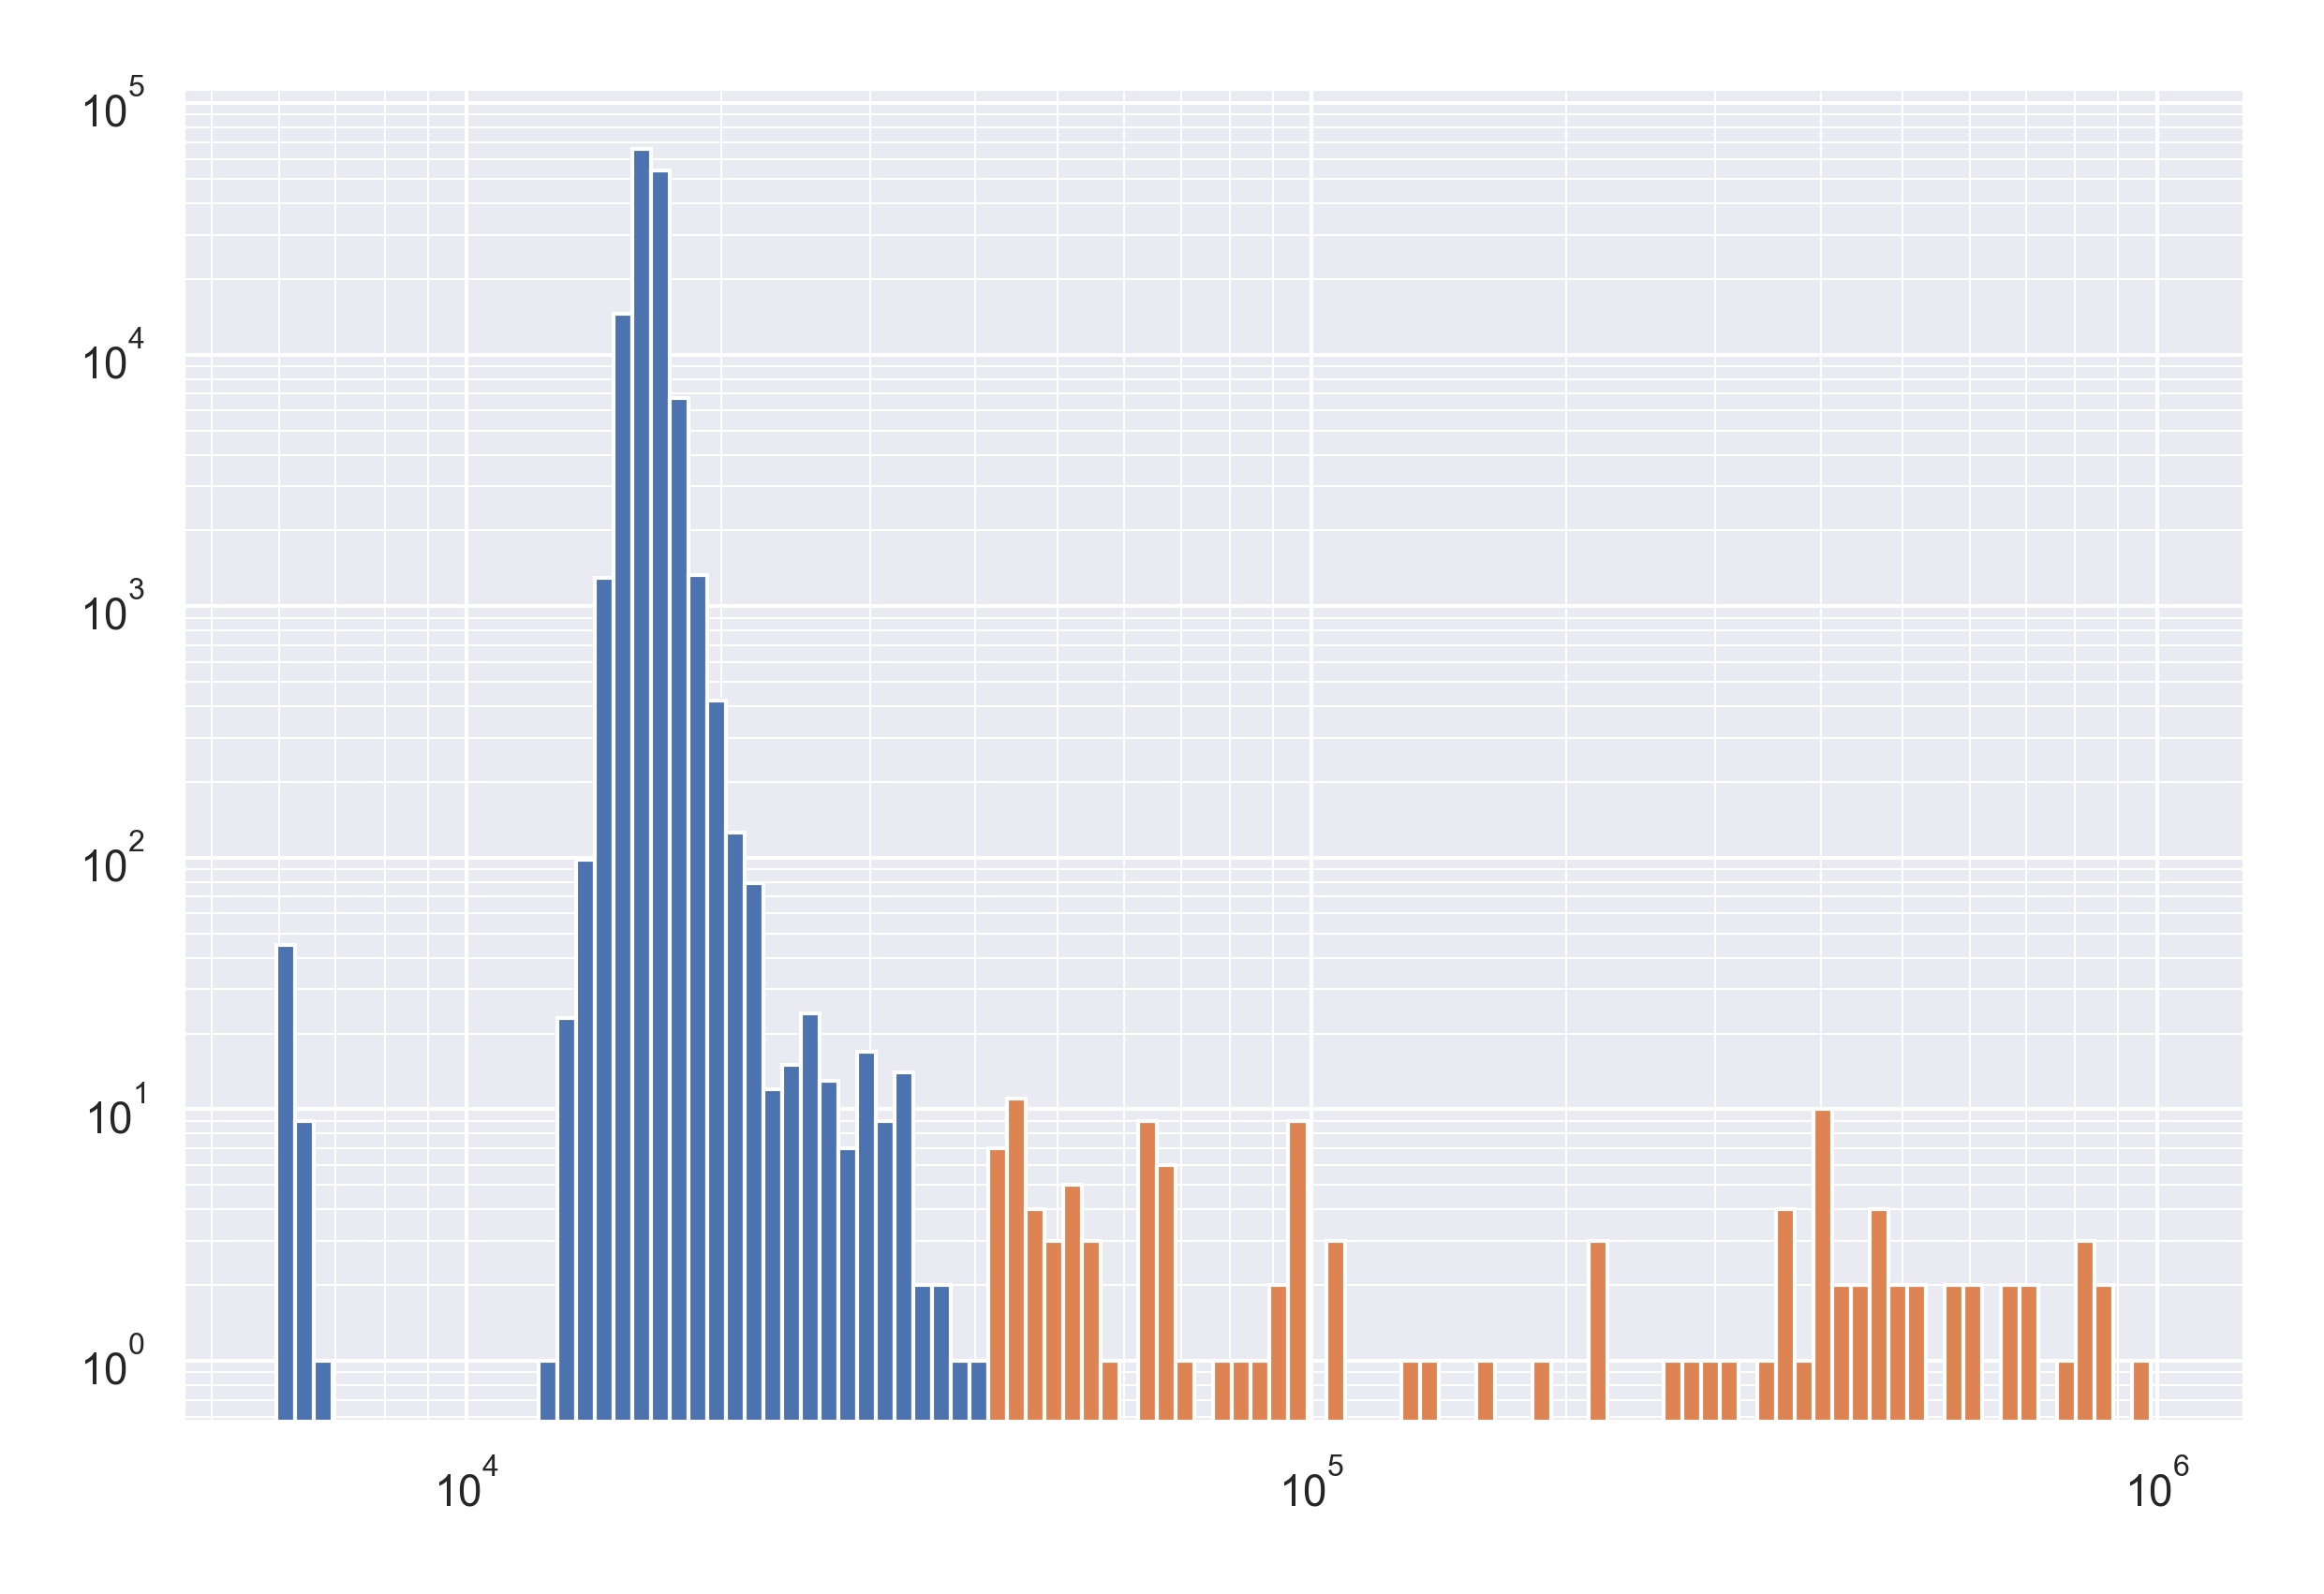

In [26]:
lens = np.asarray(lens)
hist, bins, _ = plt.hist(lens, 100)
plt.close()

fig, ax = plt.subplots()
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax.hist(lens[lens < 40_000], bins=logbins)
ax.hist(lens[lens >= 40_000], bins=logbins)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.grid(which='minor', lw=0.5)
ax.yaxis.grid(which='minor', lw=0.5)
plt.show()

In [14]:
len_distance(species.dna[5], species.dna[596])

574

In [21]:
(len(species.dna[5]) + len(species.dna[596])) // 2

802994

In [15]:
(K_len[5] < 2000).sum()

2